In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
sns.set(rc={'figure.figsize':(8,8)})
import wvlib
from adjustText import adjust_text

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def analogy(wlist, wv, num=10):
    assert len(wlist)==3
    v = wv[wlist[0]] - wv[wlist[1]] + wv[wlist[2]]
    return wv.nearest(v,n=num)
def apprx_analogy(wlist, wv, num=10):
    assert len(wlist)==3
    v = wv[wlist[0]] - wv[wlist[1]] + wv[wlist[2]]
    return wv.approximate_nearest(v,n=num)

In [3]:
def analogy_plot(rels, wv):
    # takes dataframe with columns for analogy A:B
    from sklearn.decomposition import PCA
    words = rels.iloc[:,0].tolist()
    words = rels.iloc[:,1].tolist() + words
    vecs = [wv[word] for word in words]
    pca = PCA(n_components=2) 
    pca.fit(vecs)
    df = pd.DataFrame( pca.transform(vecs))
    df.columns = ['PC1','PC2']
    df['words']=words
    
    p1 = sns.scatterplot(data=df,x='PC1',y='PC2')
    n = rels.shape[0]
    jitter = (df.PC1.max() - df.PC1.min())/200
    labels = [ 
        p1.text(df.PC1[line]+jitter, df.PC2[line], df.words[line], horizontalalignment='left', size='medium', color='black', weight='semibold') 
        for line in range(0,df.shape[0])
    ]
    adjust_text(labels)
    
    for line in range(n):
        p1.arrow( df.PC1[line], df.PC2[line], df.PC1[line+n]-df.PC1[line], df.PC2[line+n]-df.PC2[line], head_width=0.02, head_length=0.02, fc='k', ec='k')
    
    return p1

In [4]:
def closest_plot(seed, wv, num):
    # takes dataframe with columns for analogy A:B
    closest = pd.DataFrame( wv.nearest(seed,n=num), columns=['words','similarity'])
    vecs = [wv[word] for word in closest.words.tolist()]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2) 
    pca.fit(vecs)
    df = pd.DataFrame( pca.transform(vecs))
    df.columns = ['PC1','PC2']
    df['words']=closest.words
    
    p1 = sns.scatterplot(data=df,x='PC1',y='PC2')
    jitter = (df.PC1.max() - df.PC1.min())/200
    labels = [ 
        p1.text(df.PC1[line]+jitter, df.PC2[line], df.words[line], horizontalalignment='left', size='medium', color='black', weight='semibold') 
        for line in range(0,df.shape[0])
    ]
    adjust_text(labels)
        
    
    
    return p1

In [5]:
def analogy_sets( wvs, wdf, num ):
    for _,arow in wdf.iterrows():
        result = pd.DataFrame(analogy(arow.iloc[:3],wvs,num),columns=['word','similarity'])
        inthere = result.word.isin([arow.iloc[3]])
        if inthere.sum()>0:
            theone = result.loc[inthere]
            theloc = np.where(inthere)[0][0]
            print('{} - {} + {} => {}, similarity {}, rank {}'.format(
                arow.iloc[0], arow.iloc[1], arow.iloc[2],
                theone.iloc[0,0], theone.iloc[0,1], theloc
            ))
        else:
            print('{} - {} + {} => correct answer not in top {}'.format(
                arow.iloc[0], arow.iloc[1], arow.iloc[2], num
            ))

In [6]:
rels=pd.DataFrame({
    'disease':['Duchenne','HGPS','Hemophilia','Tay-Sachs','CF','Phenylketonuria'],
    'gene':['DMD','LMNA','F8','HEXA','CTFR','PAH']
})
dfs=[]
for idx,arow in rels.iterrows():
    tmp = rels.copy().drop(idx)
    tmp.columns += '_A'
    tmp['gene_B'] = arow['gene']
    tmp['disease_B'] = arow['disease']
    dfs.append(tmp)
wdf=pd.concat(dfs).reset_index(drop=True)
wdf



disease_A gene_A gene_B        disease_B
0              HGPS   LMNA    DMD         Duchenne
1        Hemophilia     F8    DMD         Duchenne
2         Tay-Sachs   HEXA    DMD         Duchenne
3                CF   CTFR    DMD         Duchenne
4   Phenylketonuria    PAH    DMD         Duchenne
5          Duchenne    DMD   LMNA             HGPS
6        Hemophilia     F8   LMNA             HGPS
7         Tay-Sachs   HEXA   LMNA             HGPS
8                CF   CTFR   LMNA             HGPS
9   Phenylketonuria    PAH   LMNA             HGPS
10         Duchenne    DMD     F8       Hemophilia
11             HGPS   LMNA     F8       Hemophilia
12        Tay-Sachs   HEXA     F8       Hemophilia
13               CF   CTFR     F8       Hemophilia
14  Phenylketonuria    PAH     F8       Hemophilia
15         Duchenne    DMD   HEXA        Tay-Sachs
16             HGPS   LMNA   HEXA        Tay-Sachs
17       Hemophilia     F8   HEXA        Tay-Sachs
18               CF   CTFR   HEXA        Tay-Sachs
19  Phenylketonuria    PAH   HEXA        Tay-Sachs
20         Duchenne    DMD   CTFR               CF
21             HGPS   LMNA   CTFR               CF
22       Hemophilia     F8   CTFR               CF
23        Tay-Sachs   HEXA   CTFR               CF
24  Phenylketonuria    PAH   CTFR               CF
25         Duchenne    DMD    PAH  Phenylketonuria
26             HGPS   LMNA    PAH  Phenylketonuria
27       Hemophilia     F8    PAH  Phenylketonuria
28        Tay-Sachs   HEXA    PAH  Phenylketonuria
29               CF   CTFR    PAH  Phenylketonuria

In [7]:
wpm_wv_n_1500k = wvlib.load("wikipedia-pubmed-and-PMC-w2v.bin").filter_by_rank(1500000).normalize()

INFO:root:loading wikipedia-pubmed-and-PMC-w2v.bin as w2vbin
DEBUG:root:reading 5443656 vectors of size 200


In [8]:
pm_wv_n_1500k = wvlib.load("PubMed-w2v.bin").filter_by_rank(1500000).normalize()

INFO:root:loading PubMed-w2v.bin as w2vbin
DEBUG:root:reading 2351706 vectors of size 200


<IPython.core.display.Javascript object>


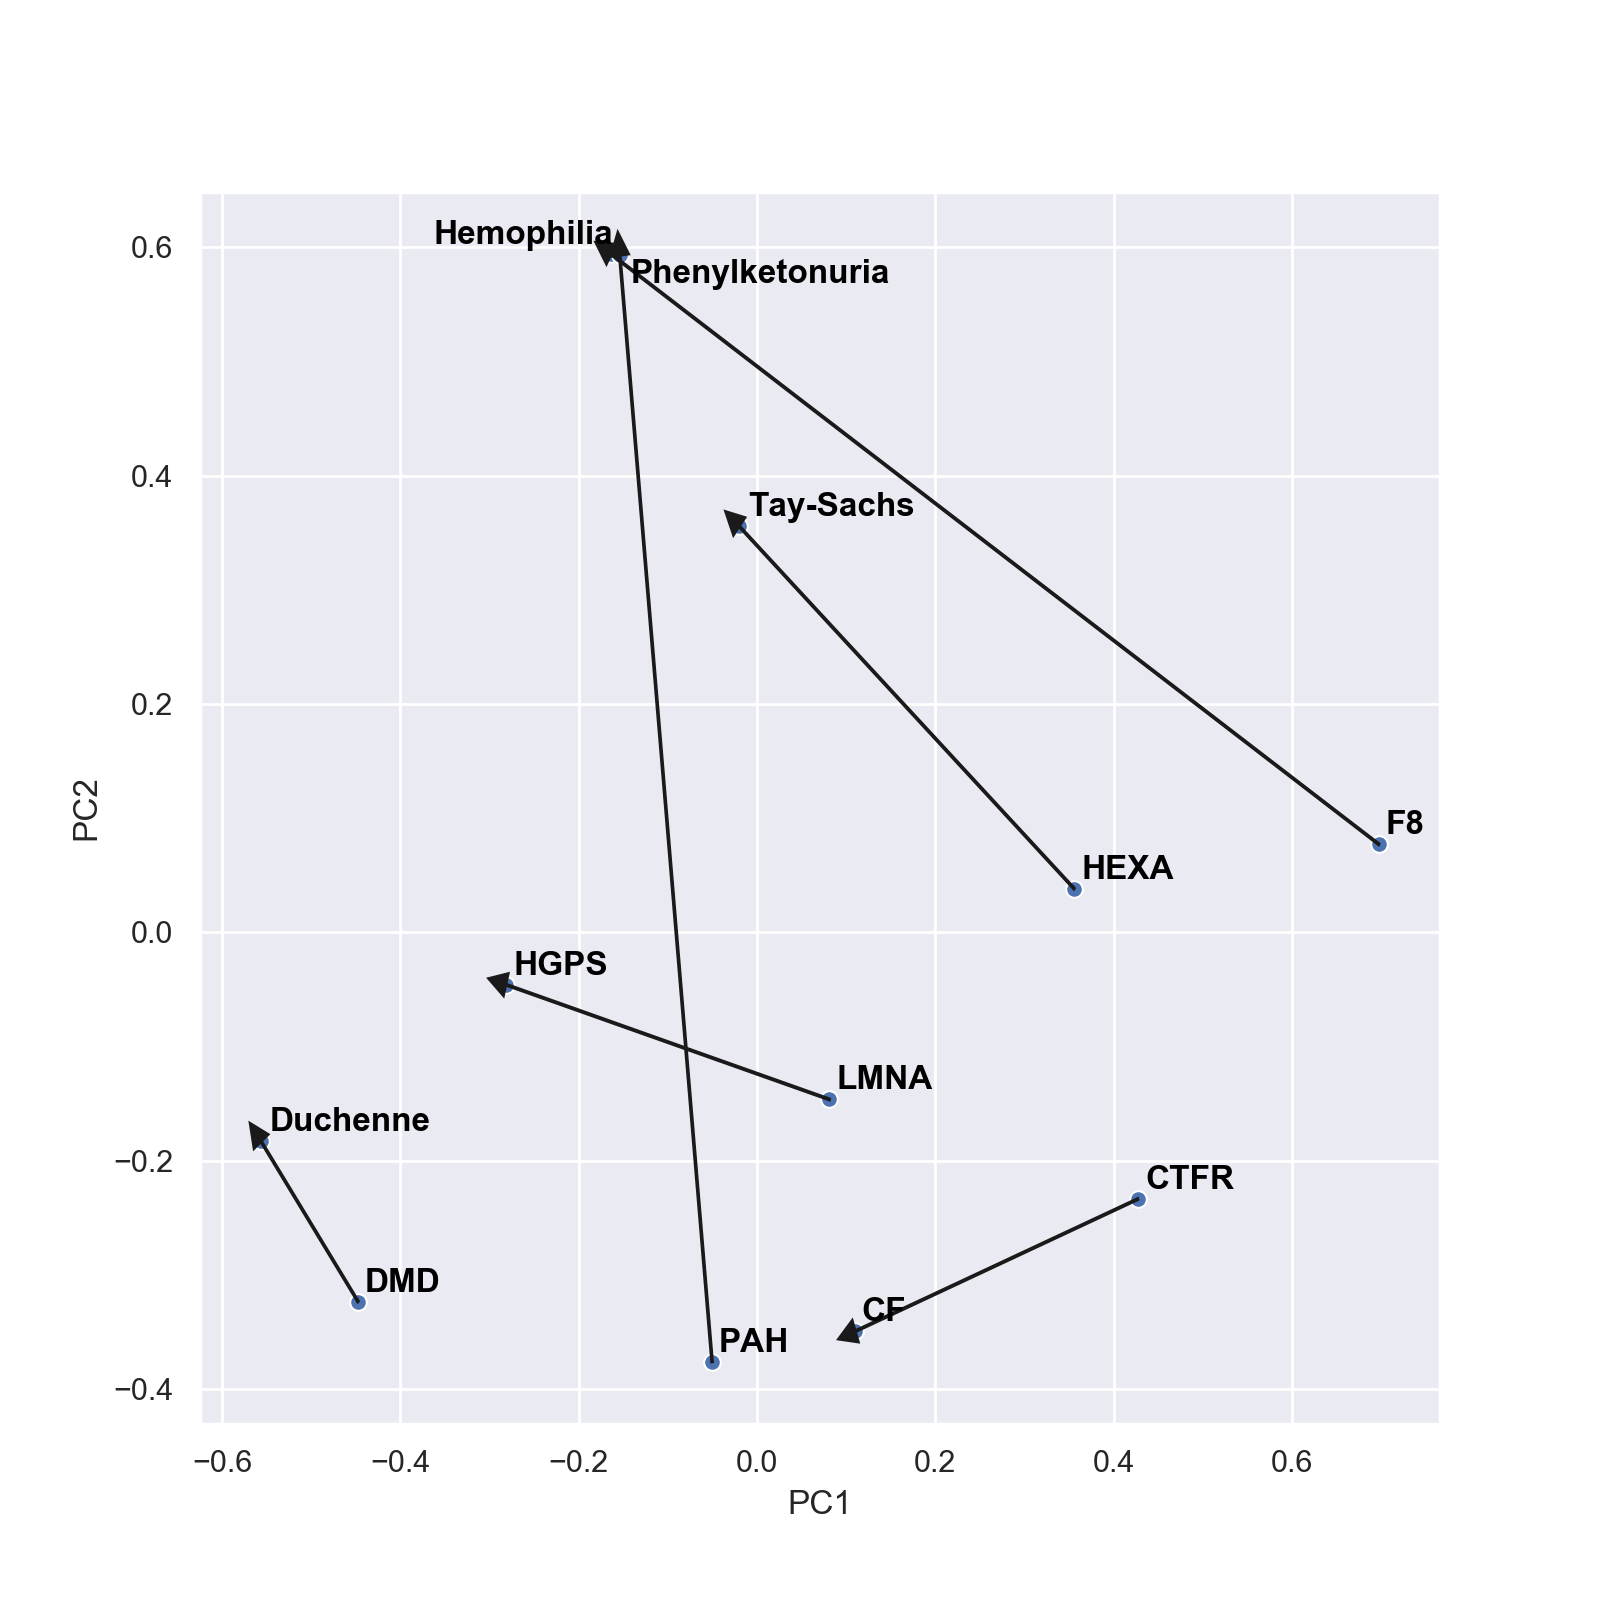

In [11]:
p1 = analogy_plot(rels,wpm_wv_n_1500k)

<IPython.core.display.Javascript object>


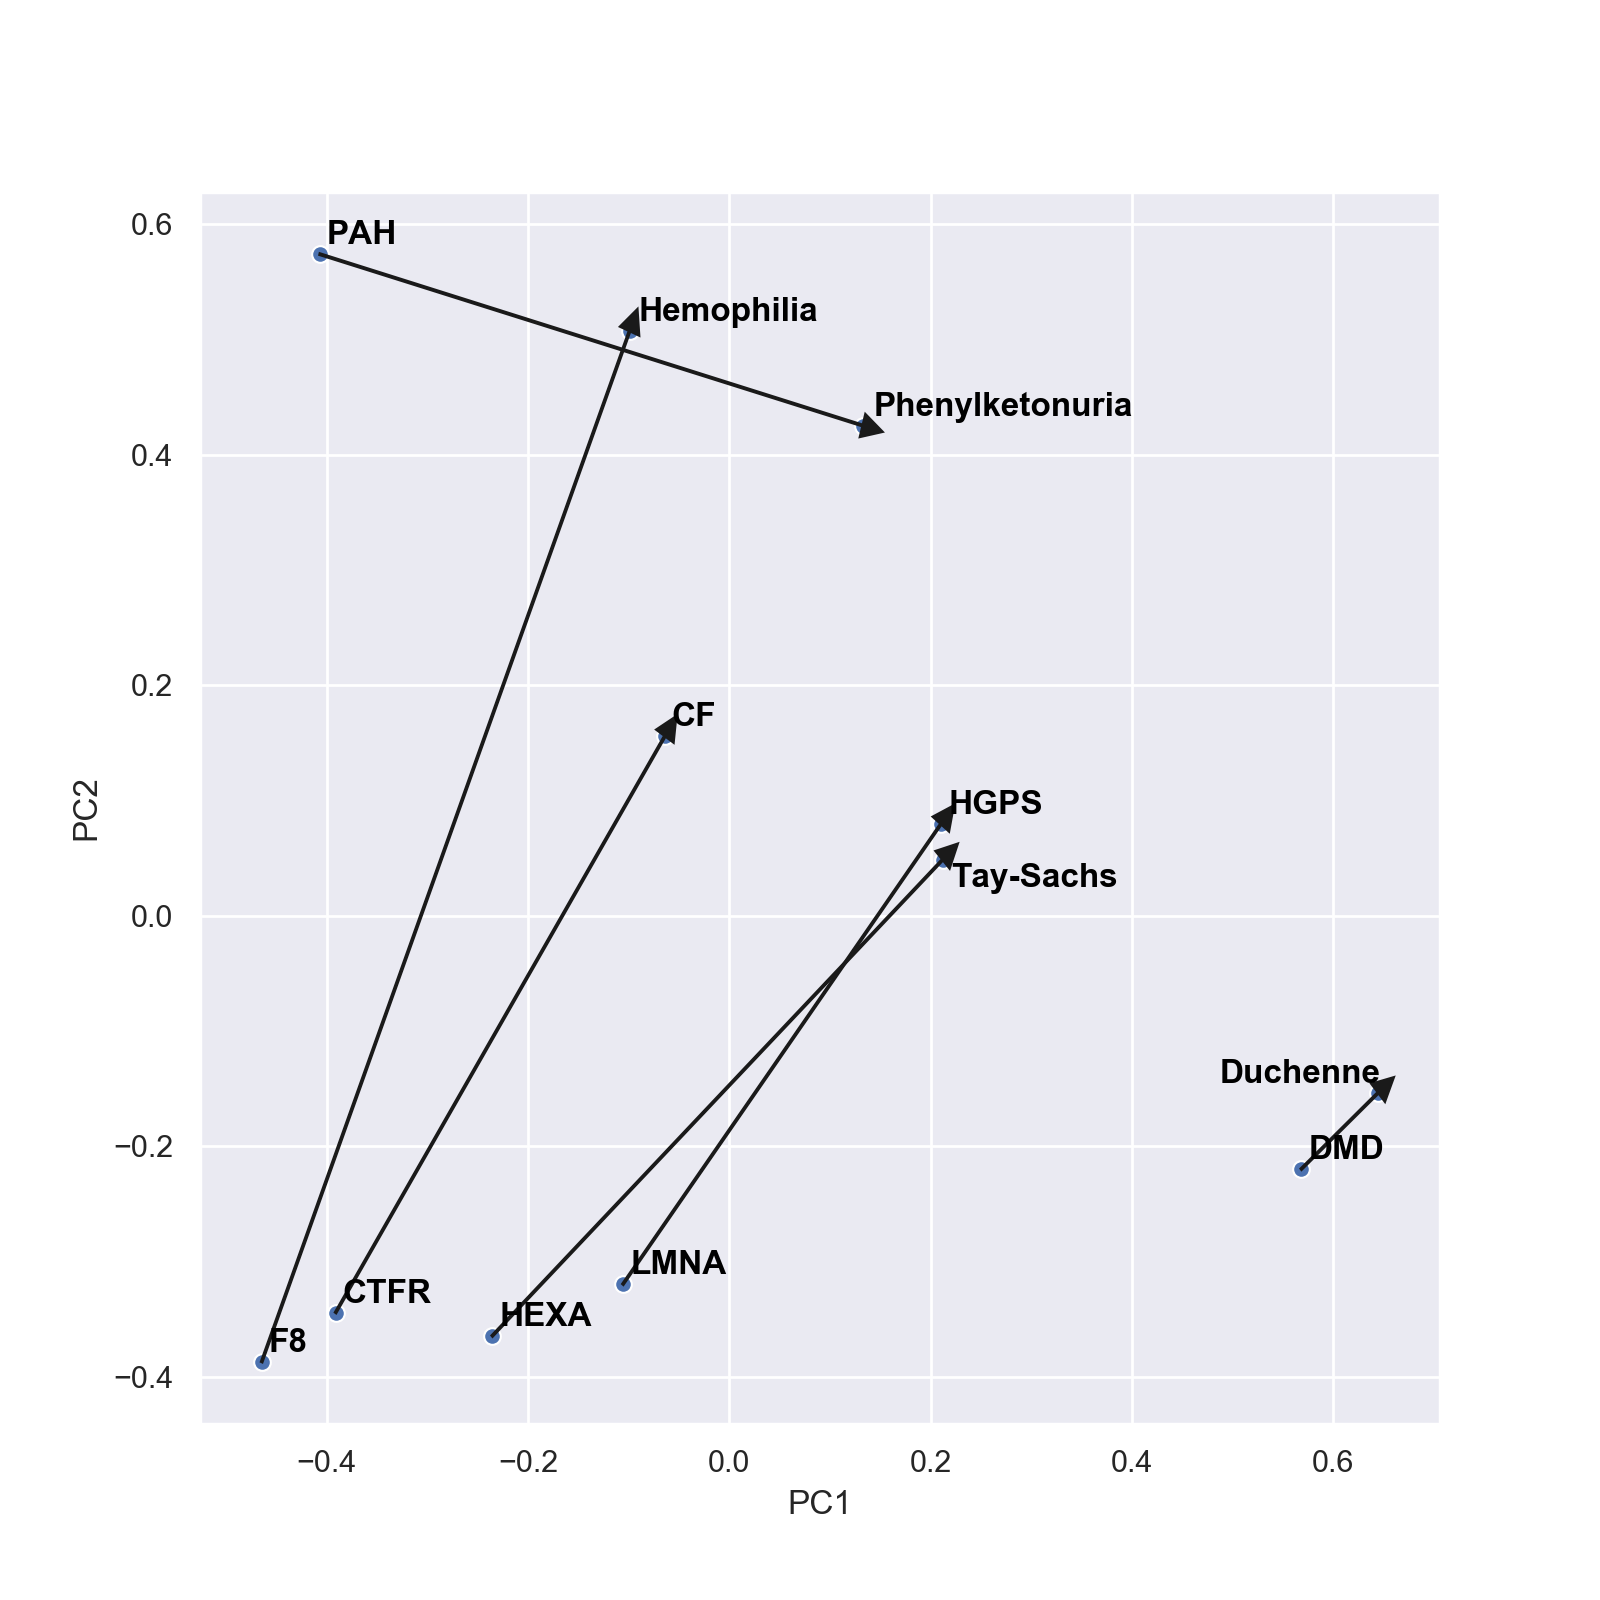

In [12]:
p1 = analogy_plot(rels,pm_wv_n_1500k)

In [11]:
analogy_sets(wpm_wv_n_1500k, wdf, 1000 )

HGPS - LMNA + DMD => Duchenne, similarity 0.6056894063949585, rank 4
Hemophilia - F8 + DMD => Duchenne, similarity 0.6340276598930359, rank 2
Tay-Sachs - HEXA + DMD => Duchenne, similarity 0.5708792805671692, rank 5
CF - CTFR + DMD => Duchenne, similarity 0.527583122253418, rank 8
Phenylketonuria - PAH + DMD => Duchenne, similarity 0.5222623348236084, rank 29
Duchenne - DMD + LMNA => correct answer not in top 1000
Hemophilia - F8 + LMNA => HGPS, similarity 0.40330880880355835, rank 97
Tay-Sachs - HEXA + LMNA => HGPS, similarity 0.5262013673782349, rank 7
CF - CTFR + LMNA => HGPS, similarity 0.4085697531700134, rank 130
Phenylketonuria - PAH + LMNA => correct answer not in top 1000
Duchenne - DMD + F8 => correct answer not in top 1000
HGPS - LMNA + F8 => correct answer not in top 1000
Tay-Sachs - HEXA + F8 => correct answer not in top 1000
CF - CTFR + F8 => correct answer not in top 1000
Phenylketonuria - PAH + F8 => correct answer not in top 1000
Duchenne - DMD + HEXA => correct answer

In [12]:
analogy_sets(pm_wv_n_1500k, wdf, 1000 )

HGPS - LMNA + DMD => Duchenne, similarity 0.5745248794555664, rank 2
Hemophilia - F8 + DMD => Duchenne, similarity 0.5387732982635498, rank 2
Tay-Sachs - HEXA + DMD => Duchenne, similarity 0.6681679487228394, rank 1
CF - CTFR + DMD => Duchenne, similarity 0.5752221345901489, rank 2
Phenylketonuria - PAH + DMD => Duchenne, similarity 0.6661738157272339, rank 1
Duchenne - DMD + LMNA => correct answer not in top 1000
Hemophilia - F8 + LMNA => correct answer not in top 1000
Tay-Sachs - HEXA + LMNA => HGPS, similarity 0.44666600227355957, rank 291
CF - CTFR + LMNA => HGPS, similarity 0.3014140725135803, rank 533
Phenylketonuria - PAH + LMNA => correct answer not in top 1000
Duchenne - DMD + F8 => correct answer not in top 1000
HGPS - LMNA + F8 => correct answer not in top 1000
Tay-Sachs - HEXA + F8 => correct answer not in top 1000
CF - CTFR + F8 => correct answer not in top 1000
Phenylketonuria - PAH + F8 => correct answer not in top 1000
Duchenne - DMD + HEXA => correct answer not in top 

In [52]:
analogy(['Tay-Sacks','HEXA','LMNA'],wdf)

KeyError: 'Tay-Sacks'

In [47]:
words = rels.iloc[:,0].tolist() + rels.iloc[:,1].tolist()
vecs = np.array([pm_wv_n_1500k[word] for word in words])
dgtarget = np.array(['disease' for i in range(rels.shape[0])] + ['gene' for i in range(rels.shape[0])])
reltarget = np.array(2*rels.iloc[:,0].tolist())

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score, accuracy_score
cval = LeaveOneOut()
#model = QuadraticDiscriminantAnalysis()
model = LinearDiscriminantAnalysis()
#model = RandomForestClassifier() #RF is a bit better, but the LDA would have been truly linearly seperable... ie the analogical direction would be good!
import warnings
warnings.simplefilter('ignore') #lots of colinearity warnings

<IPython.core.display.Javascript object>


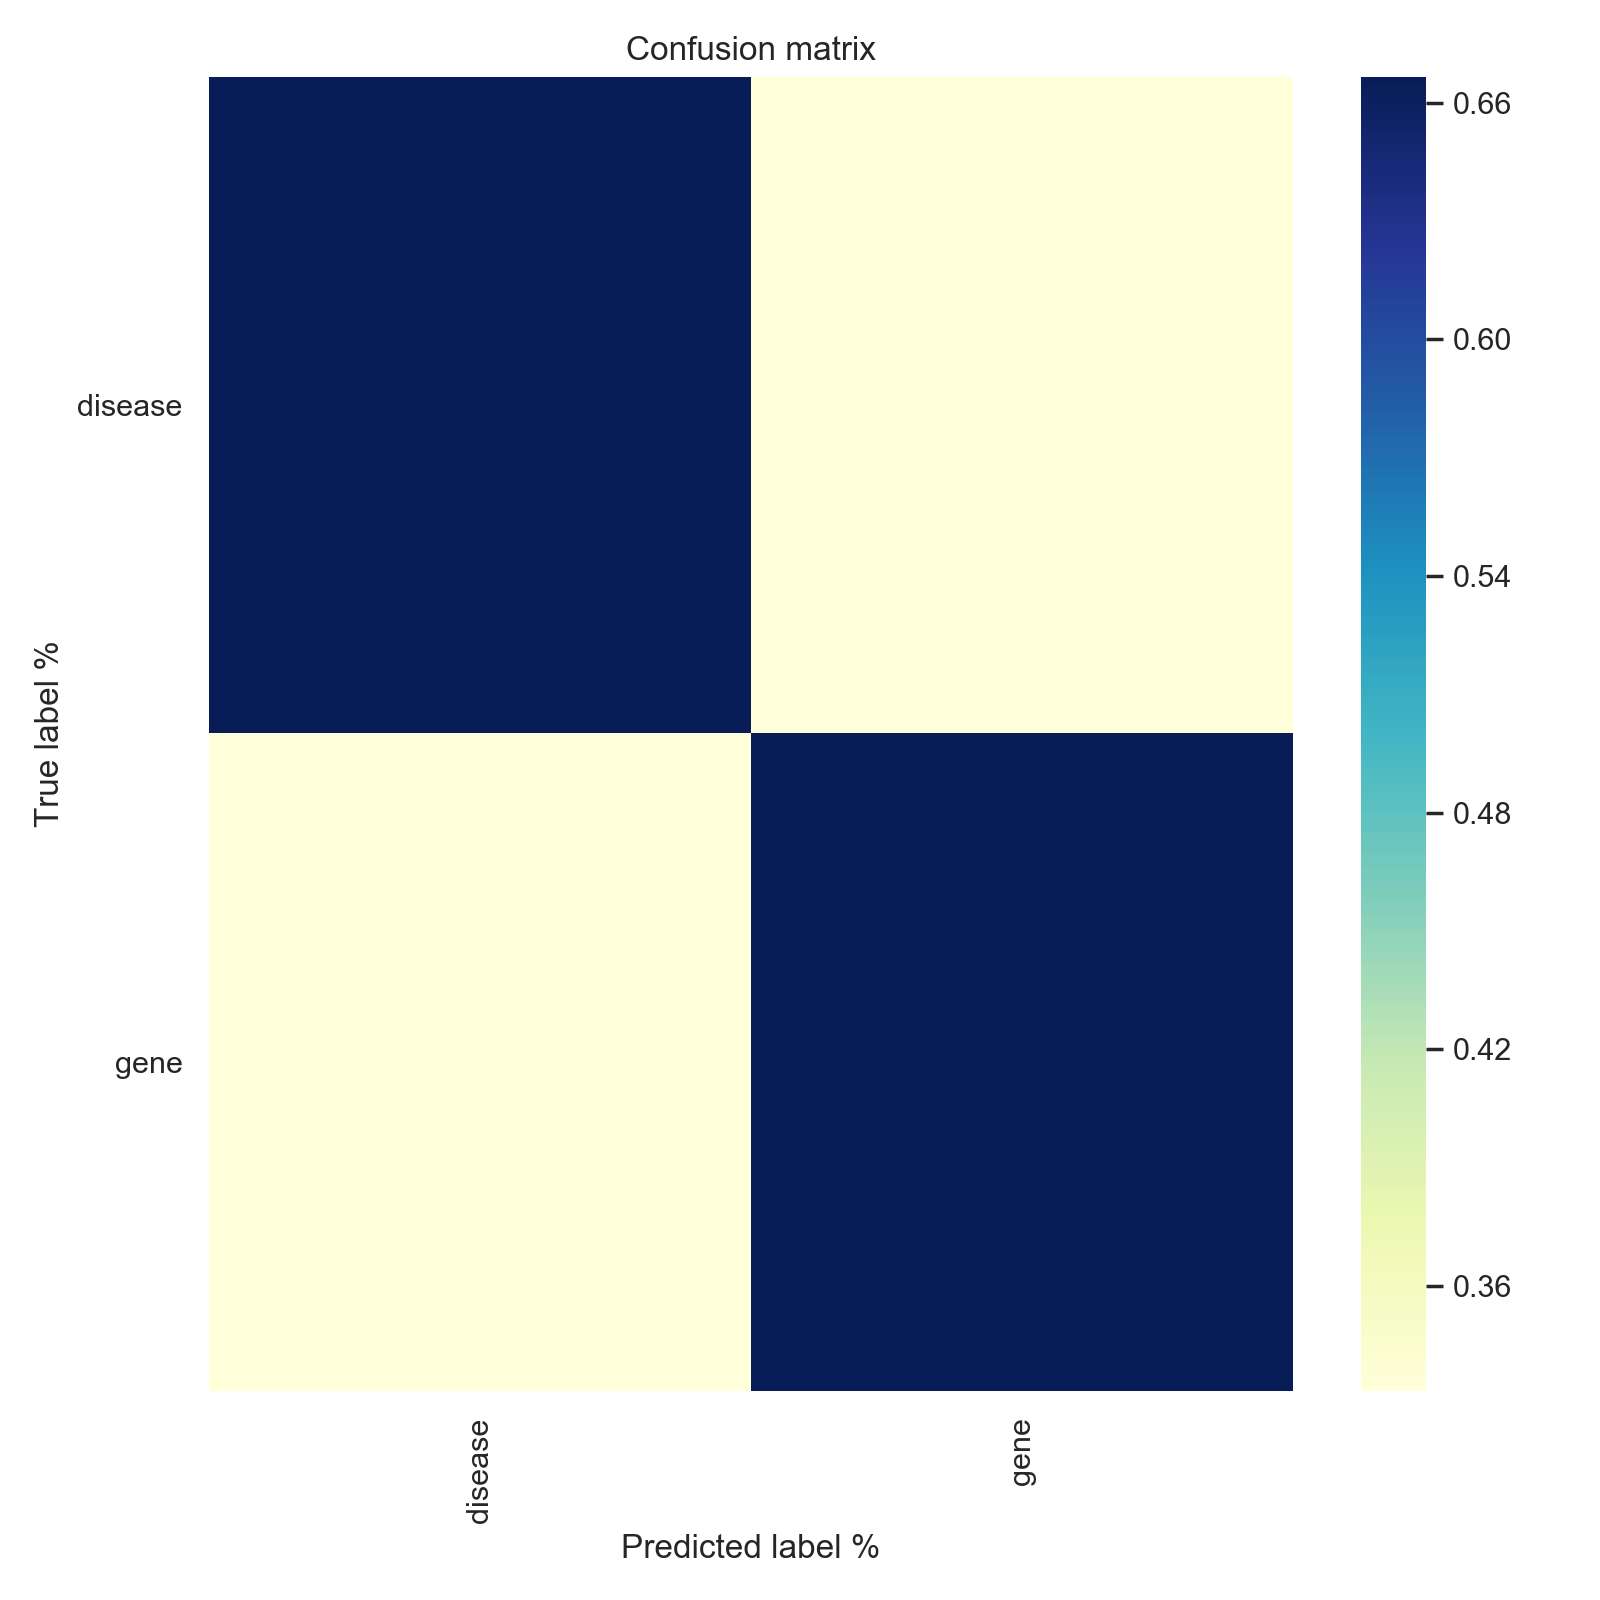

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x1aa85cbc10>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x1aa85cbc10>
DEBUG:matplotlib.colorbar:Setting pcolormesh


0.6666666666666666


In [48]:
pred = []
true = []
y = dgtarget
for train,test in cval.split(vecs):
    Xt = vecs[train]
    yt = y[train]
    model.fit(Xt,yt)
    true.append( y[test] )
    pred.append( model.predict( vecs[test]))
    
true = np.array(true).flatten()
pred = np.array(pred).flatten()
cm = pd.DataFrame( confusion_matrix(true,pred), index = model.classes_, columns = model.classes_)
cm = cm.transpose()
cm = cm / cm.sum() 
cm = cm.transpose()
ax = sns.heatmap(cm,cmap="YlGnBu");
ax.set_title('Confusion matrix');
ax.set_ylabel('True label %')
ax.set_xlabel('Predicted label %')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
yh,yl = ax.get_ylim() 
yl -= 0.5
yh += 0.5
ax.set_ylim((yl,yh))
ax.invert_yaxis()
plt.tight_layout()
print( accuracy_score(true,pred))

<IPython.core.display.Javascript object>


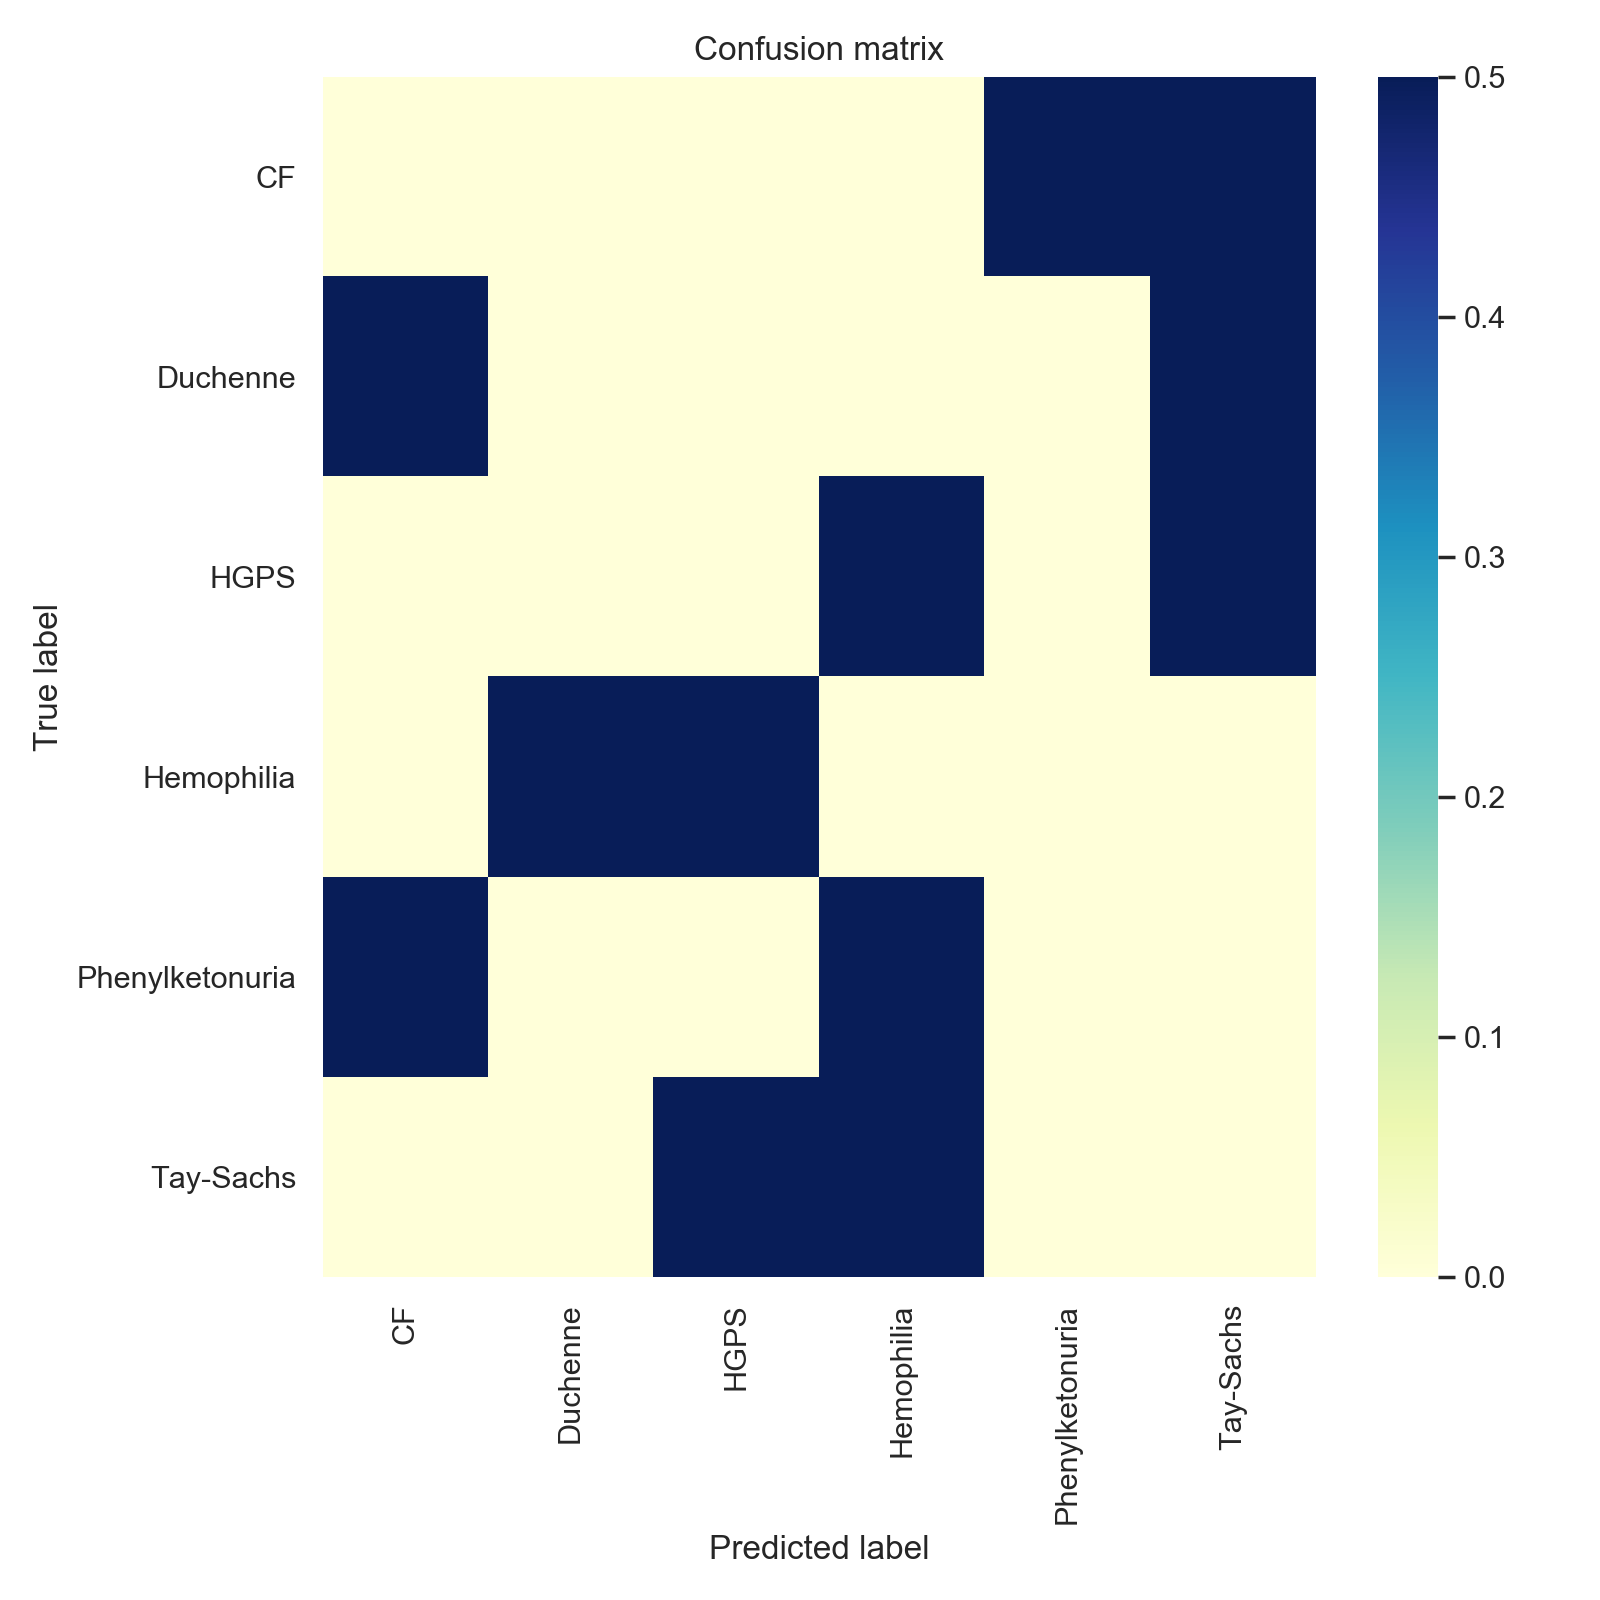

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x1aaadb5ed0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x1aaadb5ed0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


0.0


In [49]:
pred = []
true = []
y = reltarget
for train,test in cval.split(vecs):
    Xt = vecs[train]
    yt = y[train]
    model.fit(Xt,yt)
    true.append( y[test] )
    pred.append( model.predict( vecs[test]))
    
true = np.array(true).flatten()
pred = np.array(pred).flatten()
cm = pd.DataFrame( confusion_matrix(true,pred), index = model.classes_, columns = model.classes_)
cm = cm.transpose()
cm = cm / cm.sum() 
cm = cm.transpose()
ax = sns.heatmap(cm,cmap="YlGnBu");
ax.set_title('Confusion matrix');
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
yh,yl = ax.get_ylim() 
yl -= 0.5
yh += 0.5
ax.set_ylim((yl,yh))
ax.invert_yaxis()
plt.tight_layout()

print( accuracy_score(true,pred))

In [40]:
ligand_receptor = pd.read_csv('https://raw.githubusercontent.com/Teichlab/cellphonedb-data/master/data/sources/interaction_curated.csv')

In [41]:
ligand_receptor.dropna().shape, ligand_receptor.shape

((412, 7), (878, 7))

In [42]:
#def tryconvert(token,vocab):
    
ligand_receptor.partner_a[:50]#.apply( lambda x: try: pm_wv_n_1500k[x.split()[0].split('_')[0]], except: 'oops')

0                         IL12
1           ACVR_1B2A receptor
2           ACVR_1A2A receptor
3                         IL23
4           ACVR_1B2B receptor
5                 aMb2 complex
6           ACVR_1C2A receptor
7           ACVR_1A2B receptor
8                         IL27
9                      IL17 AF
10          ACVR_1C2B receptor
11                        IL35
12               a2Bb3 complex
13                aXb2 complex
14           NKG2D II receptor
15                  CD94:NKG2E
16          ACVR_1C2A receptor
17      IL1 receptor inhibitor
18               IL13 receptor
19                BMPR1B_BMPR2
20           PlexinA1_complex2
21                 BMR1A_ACR2A
22                 BMR1B_AVR2A
23    Glycoprotein Ib  complex
24                 ACVL1_BMPR2
25                 BMR1A_AVR2B
26                 BMR1B_AVR2A
27                      GMCSFR
28                 BMR1A_ACR2A
29                BMPR1B_BMPR2
30                 BMR1B_AVR2B
31          ACVR_1A2B receptor
32      

In [1]:

wv = wvlib.load("wikipedia-pubmed-and-PMC-w2v.bin")

INFO:root:loading wikipedia-pubmed-and-PMC-w2v.bin as w2vbin
DEBUG:root:reading 5443656 vectors of size 200


In [262]:
wvn = wvlib.load("wikipedia-pubmed-and-PMC-w2v.bin")
wvn.normalize()

INFO:root:loading wikipedia-pubmed-and-PMC-w2v.bin as w2vbin
DEBUG:root:reading 5443656 vectors of size 200


In [268]:
wvn250k = wvlib.load("wikipedia-pubmed-and-PMC-w2v.bin").filter_by_rank(250000).normalize()

INFO:root:loading wikipedia-pubmed-and-PMC-w2v.bin as w2vbin
DEBUG:root:reading 5443656 vectors of size 200


In [280]:
wvn2500k = wvlib.load("wikipedia-pubmed-and-PMC-w2v.bin").filter_by_rank(2500000).normalize()

INFO:root:loading wikipedia-pubmed-and-PMC-w2v.bin as w2vbin
DEBUG:root:reading 5443656 vectors of size 200


<IPython.core.display.Javascript object>


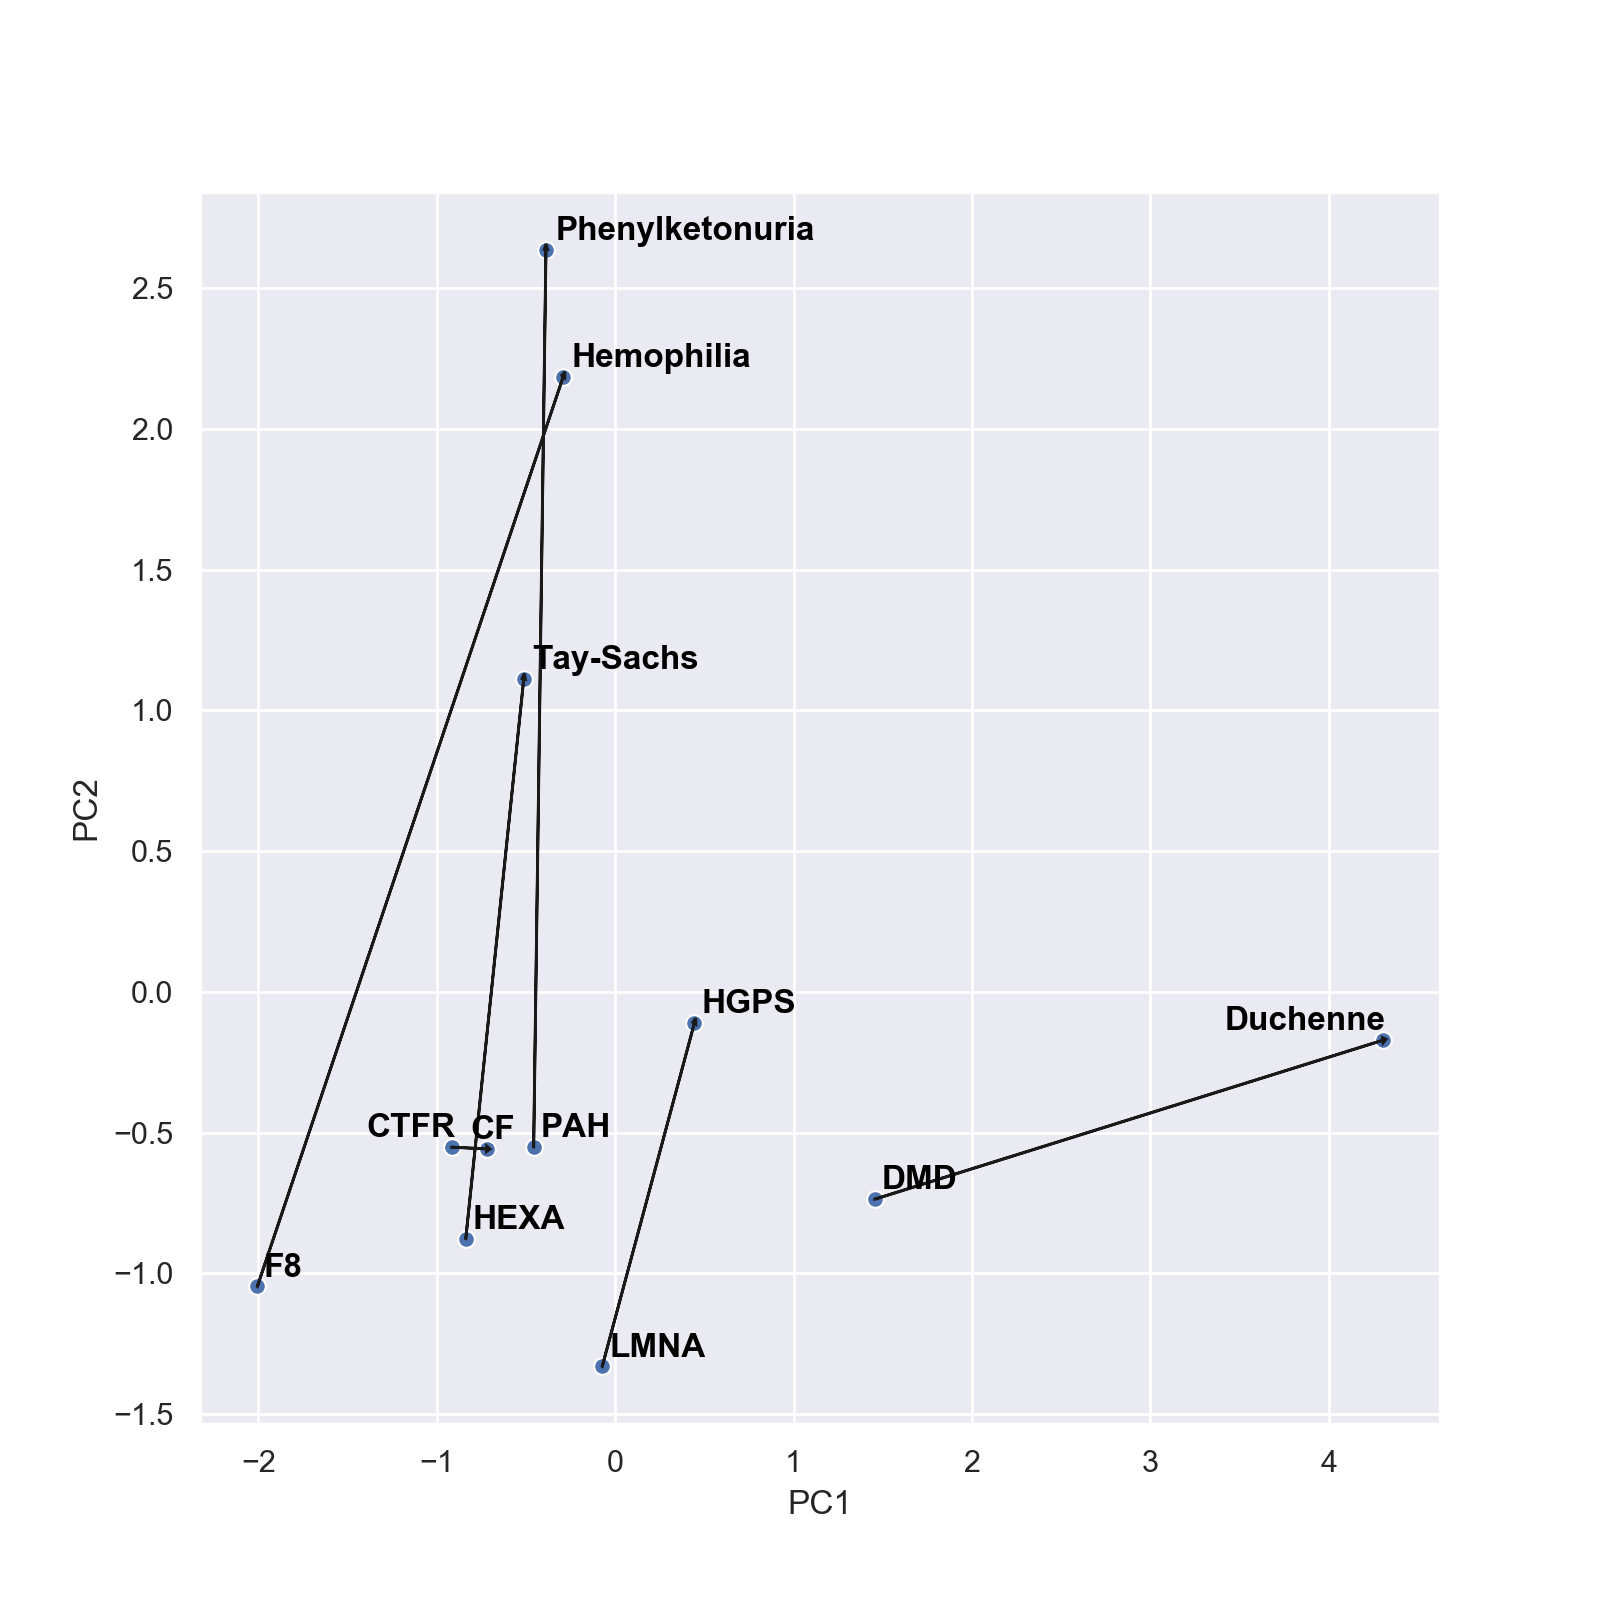

In [224]:
p1 = analogy_plot(rels,wv)

In [233]:
# uses normalized wvs

num = 100

for _,arow in wdf.iterrows():
    result = pd.DataFrame(analogy(arow.iloc[:3],wvn,num),columns=['word','similarity'])
    inthere = result.word.isin([arow.iloc[3]])
    if inthere.sum()>0:
        theone = result.loc[inthere]
        theloc = np.where(inthere)[0][0]
        print('{} - {} + {} => {}, similarity {}, rank {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2],
            theone.iloc[0,0], theone.iloc[0,1], theloc
        ))
    else:
        print('{} - {} + {} => correct answer not in top {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2], num
        ))
        


HGPS - LMNA + DMD => Duchenne, similarity 0.6056894063949585, rank 4
Hemophilia - F8 + DMD => Duchenne, similarity 0.6340276598930359, rank 2
Tay-Sachs - HEXA + DMD => Duchenne, similarity 0.5708792805671692, rank 5
CF - CTFR + DMD => Duchenne, similarity 0.527583122253418, rank 8
Phenylketonuria - PAH + DMD => Duchenne, similarity 0.5222623348236084, rank 33
Duchenne - DMD + LMNA => correct answer not in top 100
Hemophilia - F8 + LMNA => correct answer not in top 100
Tay-Sachs - HEXA + LMNA => HGPS, similarity 0.5262013673782349, rank 7
CF - CTFR + LMNA => correct answer not in top 100
Phenylketonuria - PAH + LMNA => correct answer not in top 100
Duchenne - DMD + F8 => correct answer not in top 100
HGPS - LMNA + F8 => correct answer not in top 100
Tay-Sachs - HEXA + F8 => correct answer not in top 100
CF - CTFR + F8 => correct answer not in top 100
Phenylketonuria - PAH + F8 => correct answer not in top 100
Duchenne - DMD + HEXA => correct answer not in top 100
HGPS - LMNA + HEXA => c

In [234]:
# uses non-normalized wv

num = 100

for _,arow in wdf.iterrows():
    result = pd.DataFrame(analogy(arow.iloc[:3],wv,num),columns=['word','similarity'])
    inthere = result.word.isin([arow.iloc[3]])
    if inthere.sum()>0:
        theone = result.loc[inthere]
        theloc = np.where(inthere)[0][0]
        print('{} - {} + {} => {}, similarity {}, rank {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2],
            theone.iloc[0,0], theone.iloc[0,1], theloc
        ))
    else:
        print('{} - {} + {} => correct answer not in top {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2], num
        ))
        


HGPS - LMNA + DMD => Duchenne, similarity 0.530772864818573, rank 5
Hemophilia - F8 + DMD => Duchenne, similarity 0.6078382730484009, rank 1
Tay-Sachs - HEXA + DMD => Duchenne, similarity 0.5429640412330627, rank 14
CF - CTFR + DMD => Duchenne, similarity 0.6296798586845398, rank 6
Phenylketonuria - PAH + DMD => Duchenne, similarity 0.5297316312789917, rank 67
Duchenne - DMD + LMNA => correct answer not in top 100
Hemophilia - F8 + LMNA => correct answer not in top 100
Tay-Sachs - HEXA + LMNA => HGPS, similarity 0.5509867668151855, rank 10
CF - CTFR + LMNA => correct answer not in top 100
Phenylketonuria - PAH + LMNA => correct answer not in top 100
Duchenne - DMD + F8 => correct answer not in top 100
HGPS - LMNA + F8 => correct answer not in top 100
Tay-Sachs - HEXA + F8 => correct answer not in top 100
CF - CTFR + F8 => correct answer not in top 100
Phenylketonuria - PAH + F8 => correct answer not in top 100
Duchenne - DMD + HEXA => correct answer not in top 100
HGPS - LMNA + HEXA =>

In [236]:
arow = wdf.iloc[0]
print('{} - {} + {} => {}???'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2], arow.iloc[3]
        ))
analogy(arow.iloc[:3],wv,25)

HGPS - LMNA + DMD => Duchenne???


[('HGPS', 0.6593614),
 ('DMD', 0.622887),
 ('Hutchinson-Gilford', 0.57787055),
 ('progeria', 0.5589496),
 ('FSHD', 0.53535396),
 ('Duchenne', 0.53077286),
 ('Progeria', 0.49993438),
 ('myotonic', 0.4979211),
 ('MDC1A', 0.4919023),
 ('progeroid', 0.48798805),
 ('merosin-deficient', 0.48417532),
 ('facioscapulohumeral', 0.48317116),
 ('OPMD', 0.4800011),
 ('duchenne', 0.47965577),
 ('EDMD', 0.47499654),
 ('limb-girdle', 0.46921527),
 ('oculopharyngeal', 0.46910757),
 ('Emery-Dreifuss', 0.46760362),
 ('Duchenne-type', 0.46757907),
 ('dystrophy', 0.46696386),
 ('Walker-Warburg', 0.4657925),
 ('MyD', 0.46474802),
 ('Becker-Kiner', 0.4617257),
 ('thoracic-pelvic-phalangeal', 0.46131504),
 ('Ribosuria', 0.45861793)]

In [237]:
arow = wdf.iloc[5]
print('{} - {} + {} => {}???'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2], arow.iloc[3]
        ))
analogy(arow.iloc[:3],wv,25)

Duchenne - DMD + LMNA => HGPS???


[('LMNA', 0.7802312),
 ('Duchenne', 0.777722),
 ('Emery-Dreifuss', 0.7582763),
 ('limb-girdle', 0.701179),
 ('Duchenne/Becker', 0.7004802),
 ('EDMD', 0.691915),
 ('facioscapulohumeral', 0.6876488),
 ('oculopharyngeal', 0.6720016),
 ('duchenne', 0.6672349),
 ('myotonic', 0.6651579),
 ('Oculopharyngeal', 0.6559676),
 ('Facioscapulohumeral', 0.64681613),
 ('Limb-girdle', 0.641435),
 ('Fukuyama-type', 0.63831204),
 ('CAV3', 0.63710225),
 ('Duchenne-type', 0.6339418),
 ('BSCL2', 0.63236344),
 ('D596N', 0.6298761),
 ('FCMD', 0.6254939),
 ('DYSF', 0.6253204),
 ('L-CMD', 0.6214026),
 ('Becker-type', 0.6197799),
 ('Limb-Girdle', 0.61884284),
 ('SPG3A', 0.61661553),
 ('MFN2', 0.61635756)]

In [147]:
analogy(["CD19+", "B-Cell" , "Monocyte"],wv,20) #should be CD14+ CD16+

[('monocyte', 0.7016306),
 ('CD14+', 0.6727905),
 ('monocytes', 0.67099816),
 ('CD19+', 0.66304374),
 ('Monocyte', 0.6594006),
 ('CD45+', 0.6486178),
 ('CD16+', 0.6452874),
 ('Gr-1+', 0.62901),
 ('monocytes/macrophages', 0.62884974),
 ('CD16-negative', 0.62409765),
 ('CD14-', 0.62198925),
 ('CD11b+F4/80+', 0.6213922),
 ('Ly-6Ghi', 0.62081724),
 ('CD14-positive', 0.61854875),
 ('Ly6G+', 0.6177247),
 ('CD3+', 0.61572635),
 ('CD16-', 0.615606),
 ('F4/80+', 0.6120161),
 ('granulocytes', 0.61179817),
 ('neutrophils', 0.61076283)]

In [152]:
analogy(['astrocytoma', "astrocyte", "B-cell"],wv,20) # should be lymphoma

[('B-cell', 0.7817744),
 ('large-cell', 0.77017117),
 ('lymphoma', 0.7691364),
 ('B-NHL', 0.7681713),
 ('lymphomas', 0.7669107),
 ('DLBCL', 0.76268506),
 ('centrocytic', 0.7514691),
 ('mantle-cell', 0.749162),
 ('ALCL', 0.7465883),
 ('immunoblastic', 0.74608743),
 ('anaplastic', 0.74283254),
 ('T-NHL', 0.74084055),
 ('DLBL', 0.7364497),
 ('centroblastic', 0.73509115),
 ('DLCL', 0.73353726),
 ('centroblastic-centrocytic', 0.73306286),
 ('B-immunoblastic', 0.7312833),
 ('Burkitt-type', 0.7257923),
 ('centroblastic/centrocytic', 0.71778727),
 ('CD30-positive', 0.71397305)]

In [160]:
analogy([ "ADHD", "amphetamine", "SSRI"],wvn,20)

[('ADHD', 0.76192516),
 ('MDD', 0.6629589),
 ('AD/HD', 0.65430886),
 ('attention-deficit/hyperactivity', 0.65307677),
 ('SSRI', 0.65194976),
 ('OCD', 0.6370332),
 ('ODD/CD', 0.63003623),
 ('schizophrenia', 0.6285156),
 ('ASD', 0.62728655),
 ('ASDs', 0.6226888),
 ('ADDH', 0.621972),
 ('attention-deficit-hyperactivity', 0.6192044),
 ('autism', 0.60871),
 ('SRIs', 0.6038547),
 ('BPD', 0.60344124),
 ('disorder/attention-deficit/hyperactivity', 0.6028291),
 ('autism-spectrum', 0.6017388),
 ('dysthymic', 0.59836054),
 ('CD/ODD', 0.59607613),
 ('medication-naive', 0.59293056)]

In [151]:
analogy(["diabetes", "insulin", "obesity"],wv,20)

[('diabetes', 0.79109025),
 ('obesity', 0.7434188),
 ('overweight/obesity', 0.6934197),
 ('HTN', 0.6749723),
 ('T2DM', 0.6749215),
 ('T1DM', 0.66622245),
 ('mellitus', 0.6580677),
 ('obesity/overweight', 0.6559948),
 ('prehypertension', 0.6556212),
 ('prediabetes', 0.65529037),
 ('CVD', 0.63708436),
 ('hyperlipidemia', 0.6346408),
 ('T2D', 0.63028246),
 ('DM2', 0.6272299),
 ('youth-onset', 0.6248819),
 ('pre-diabetes', 0.6248444),
 ('hypertension', 0.6236359),
 ('dyslipidemia', 0.6200045),
 ('CNCDs', 0.6158063),
 ('pre-hypertension', 0.61478406)]

<IPython.core.display.Javascript object>


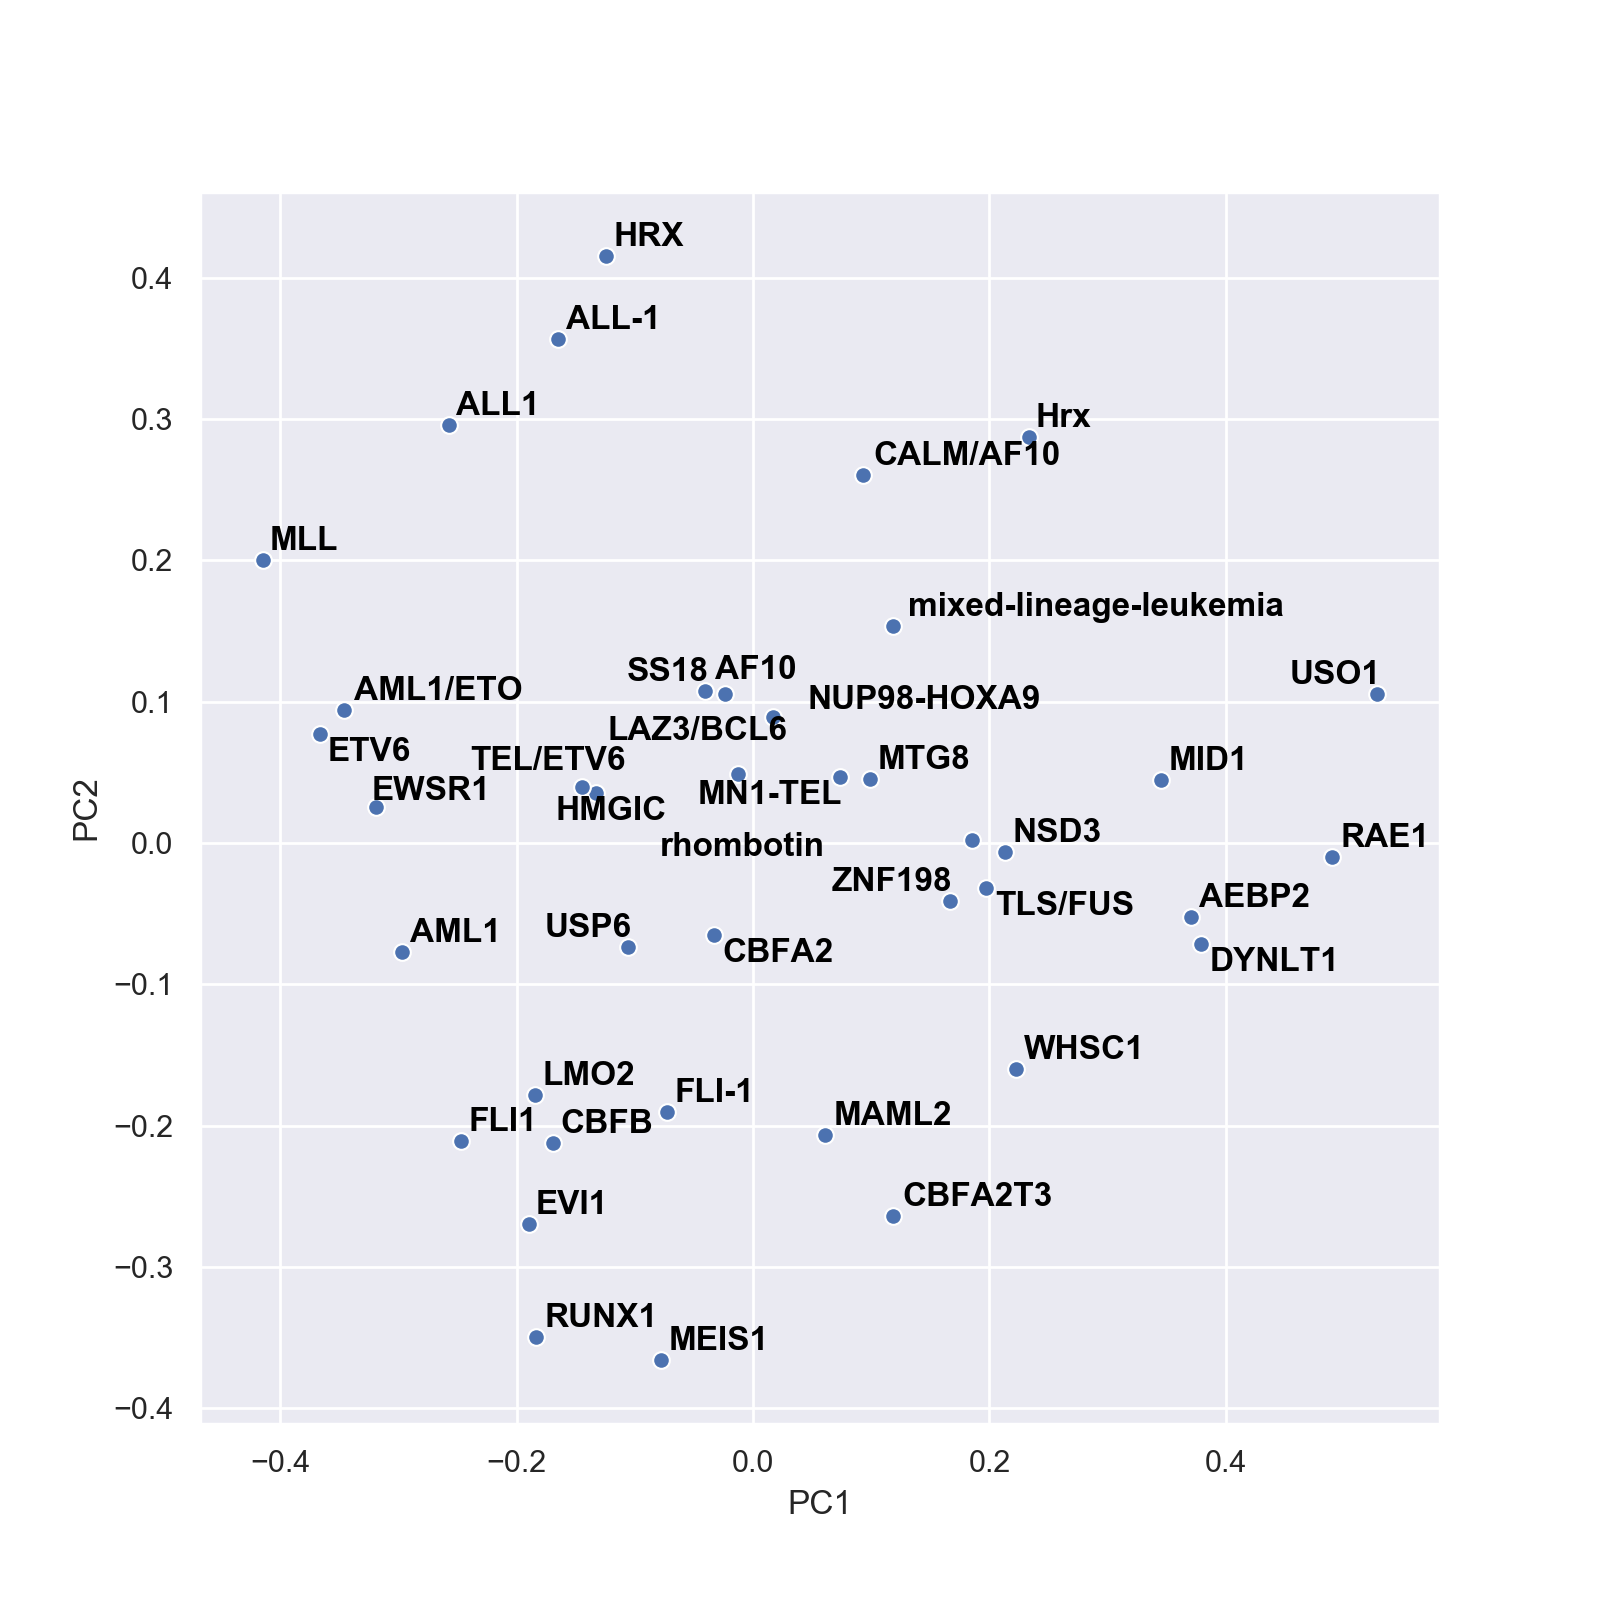

In [238]:
closest_plot('NUP98',wvn,40);

<IPython.core.display.Javascript object>


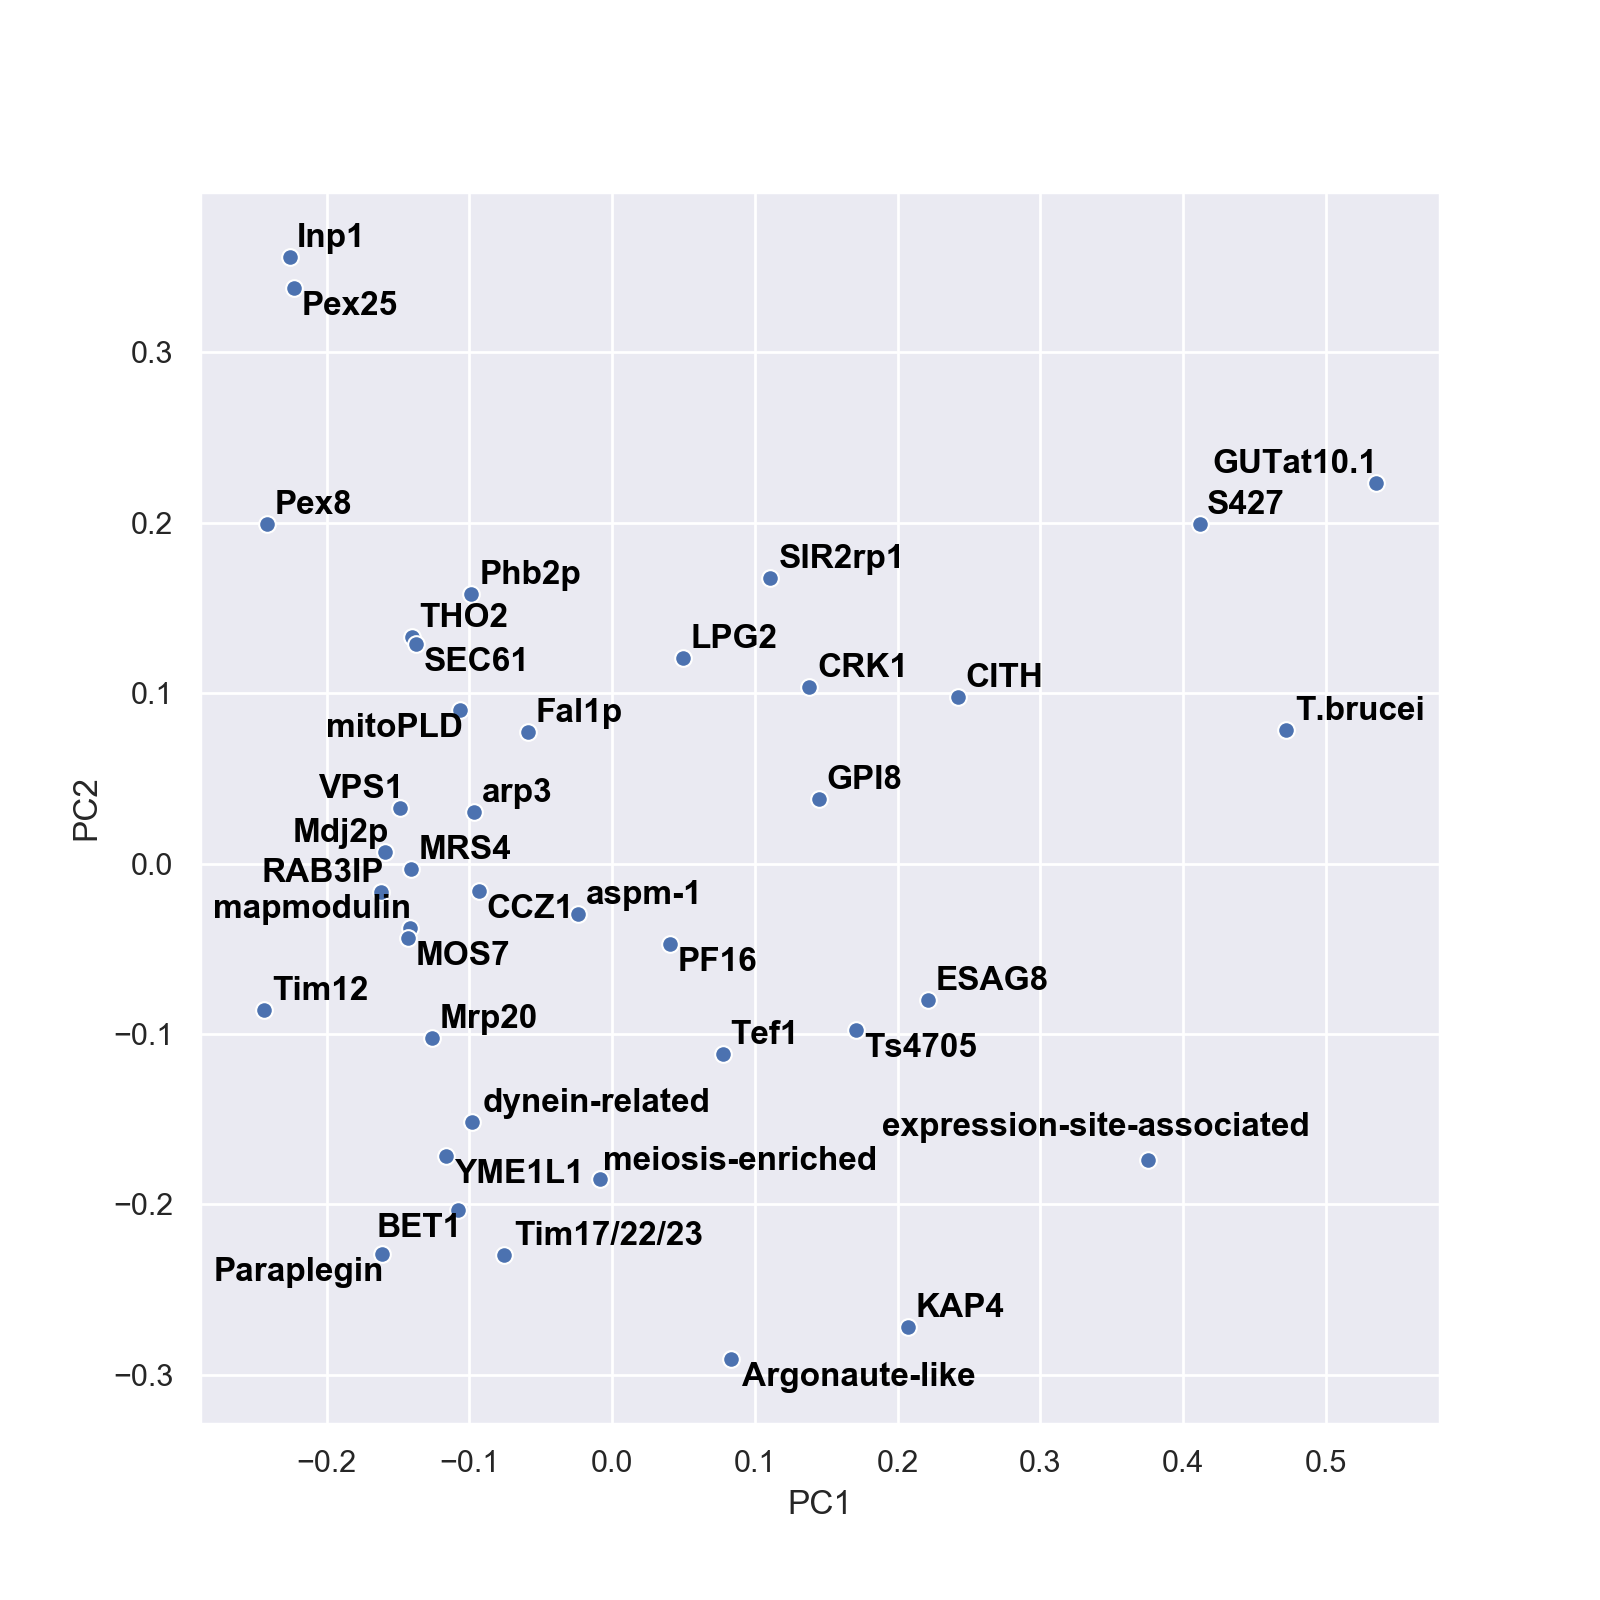

In [239]:
closest_plot('NUP96',wvn,40);

In [244]:
wvn10k = wvn.filter_by_rank(10000)
wvn5k = wvn10k.filter_by_rank(5000)
wvn1k = wvn5k.filter_by_rank(1000)

<IPython.core.display.Javascript object>


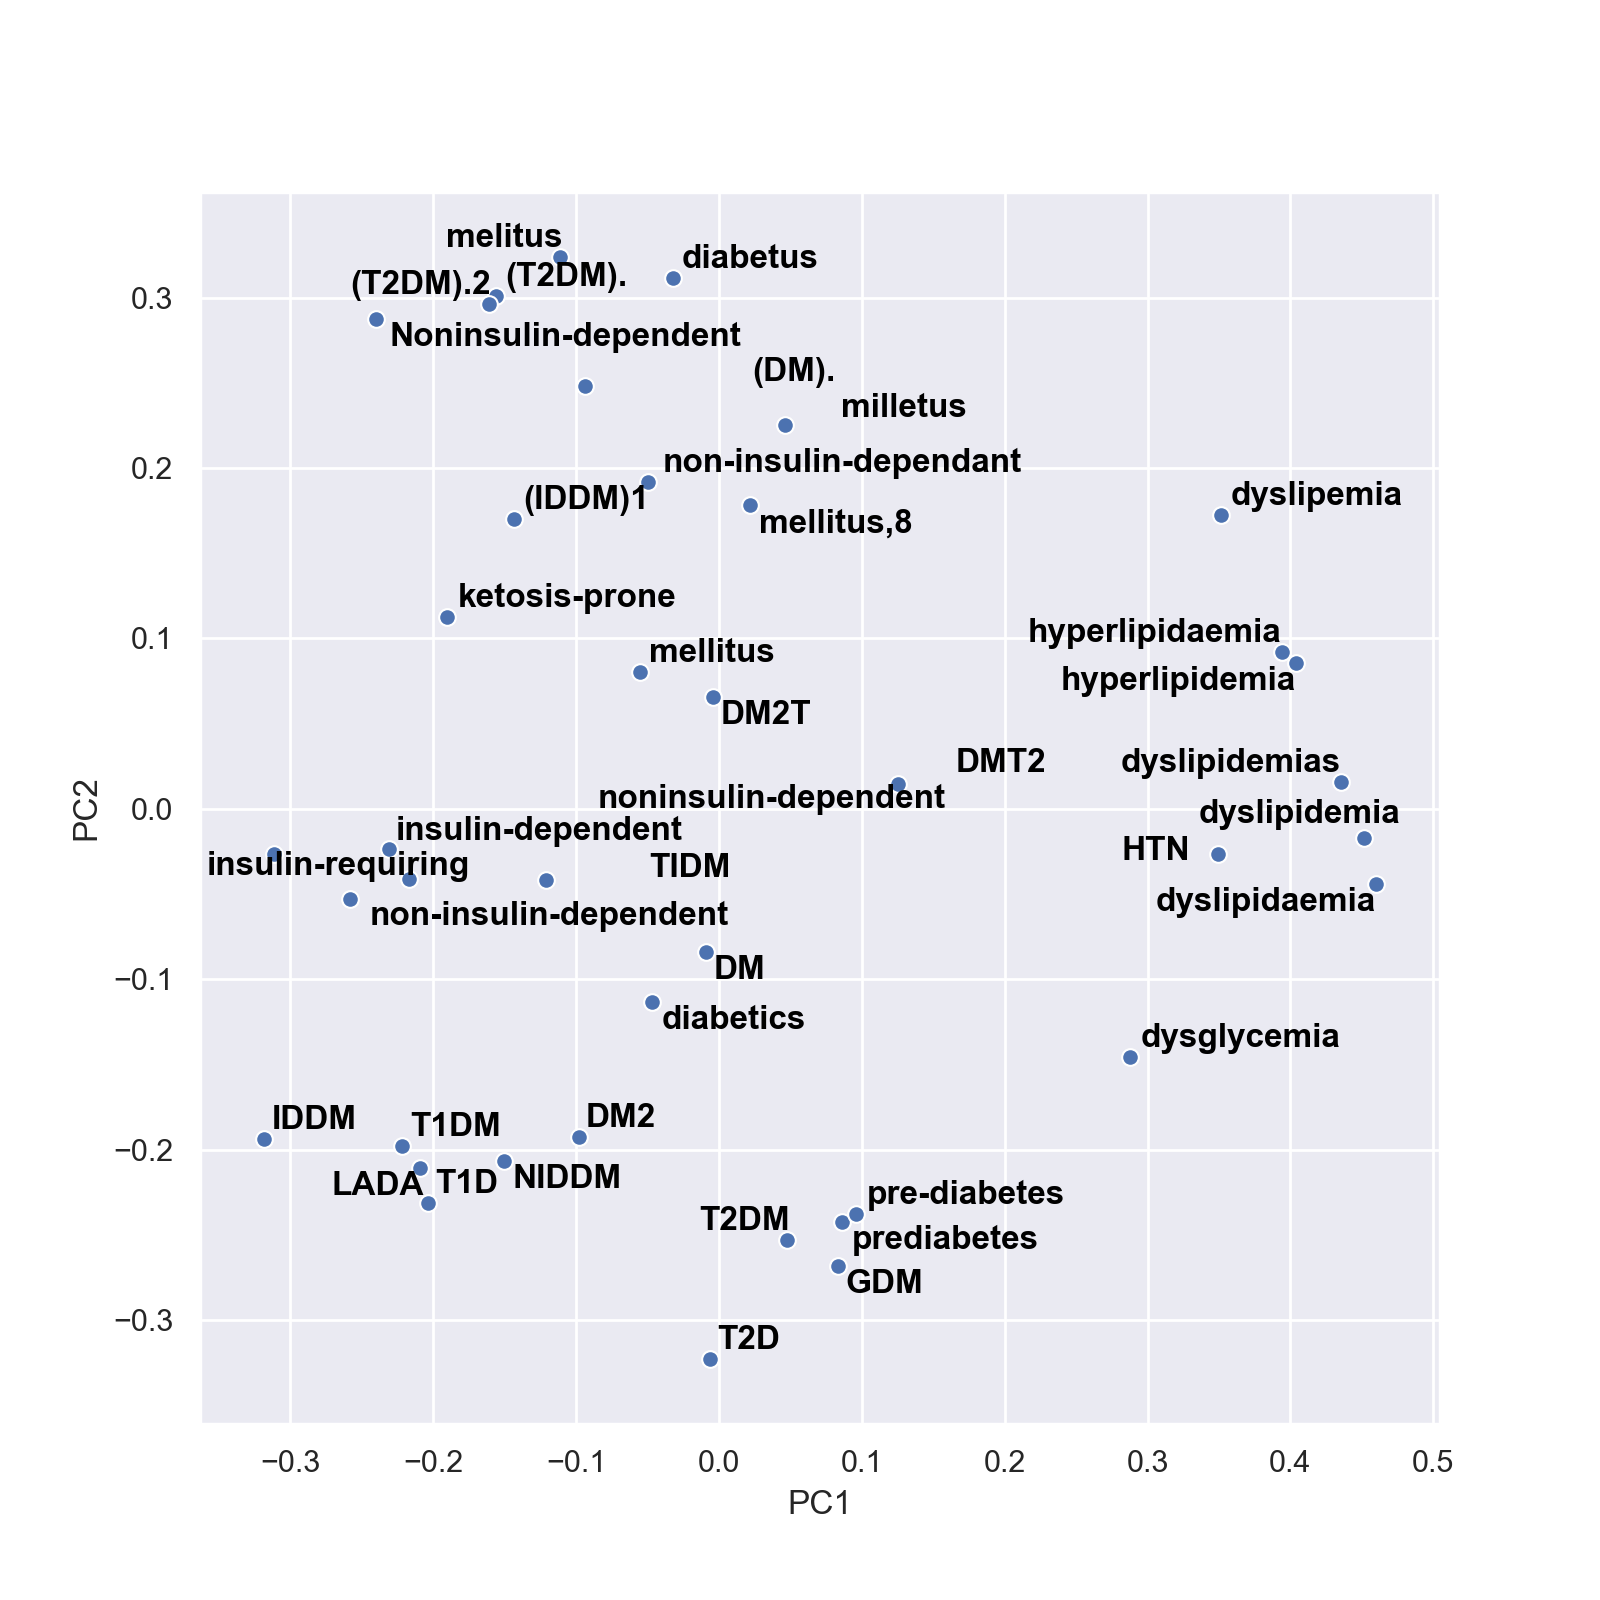

In [240]:
closest_plot('diabetes',wvn,40);

<IPython.core.display.Javascript object>


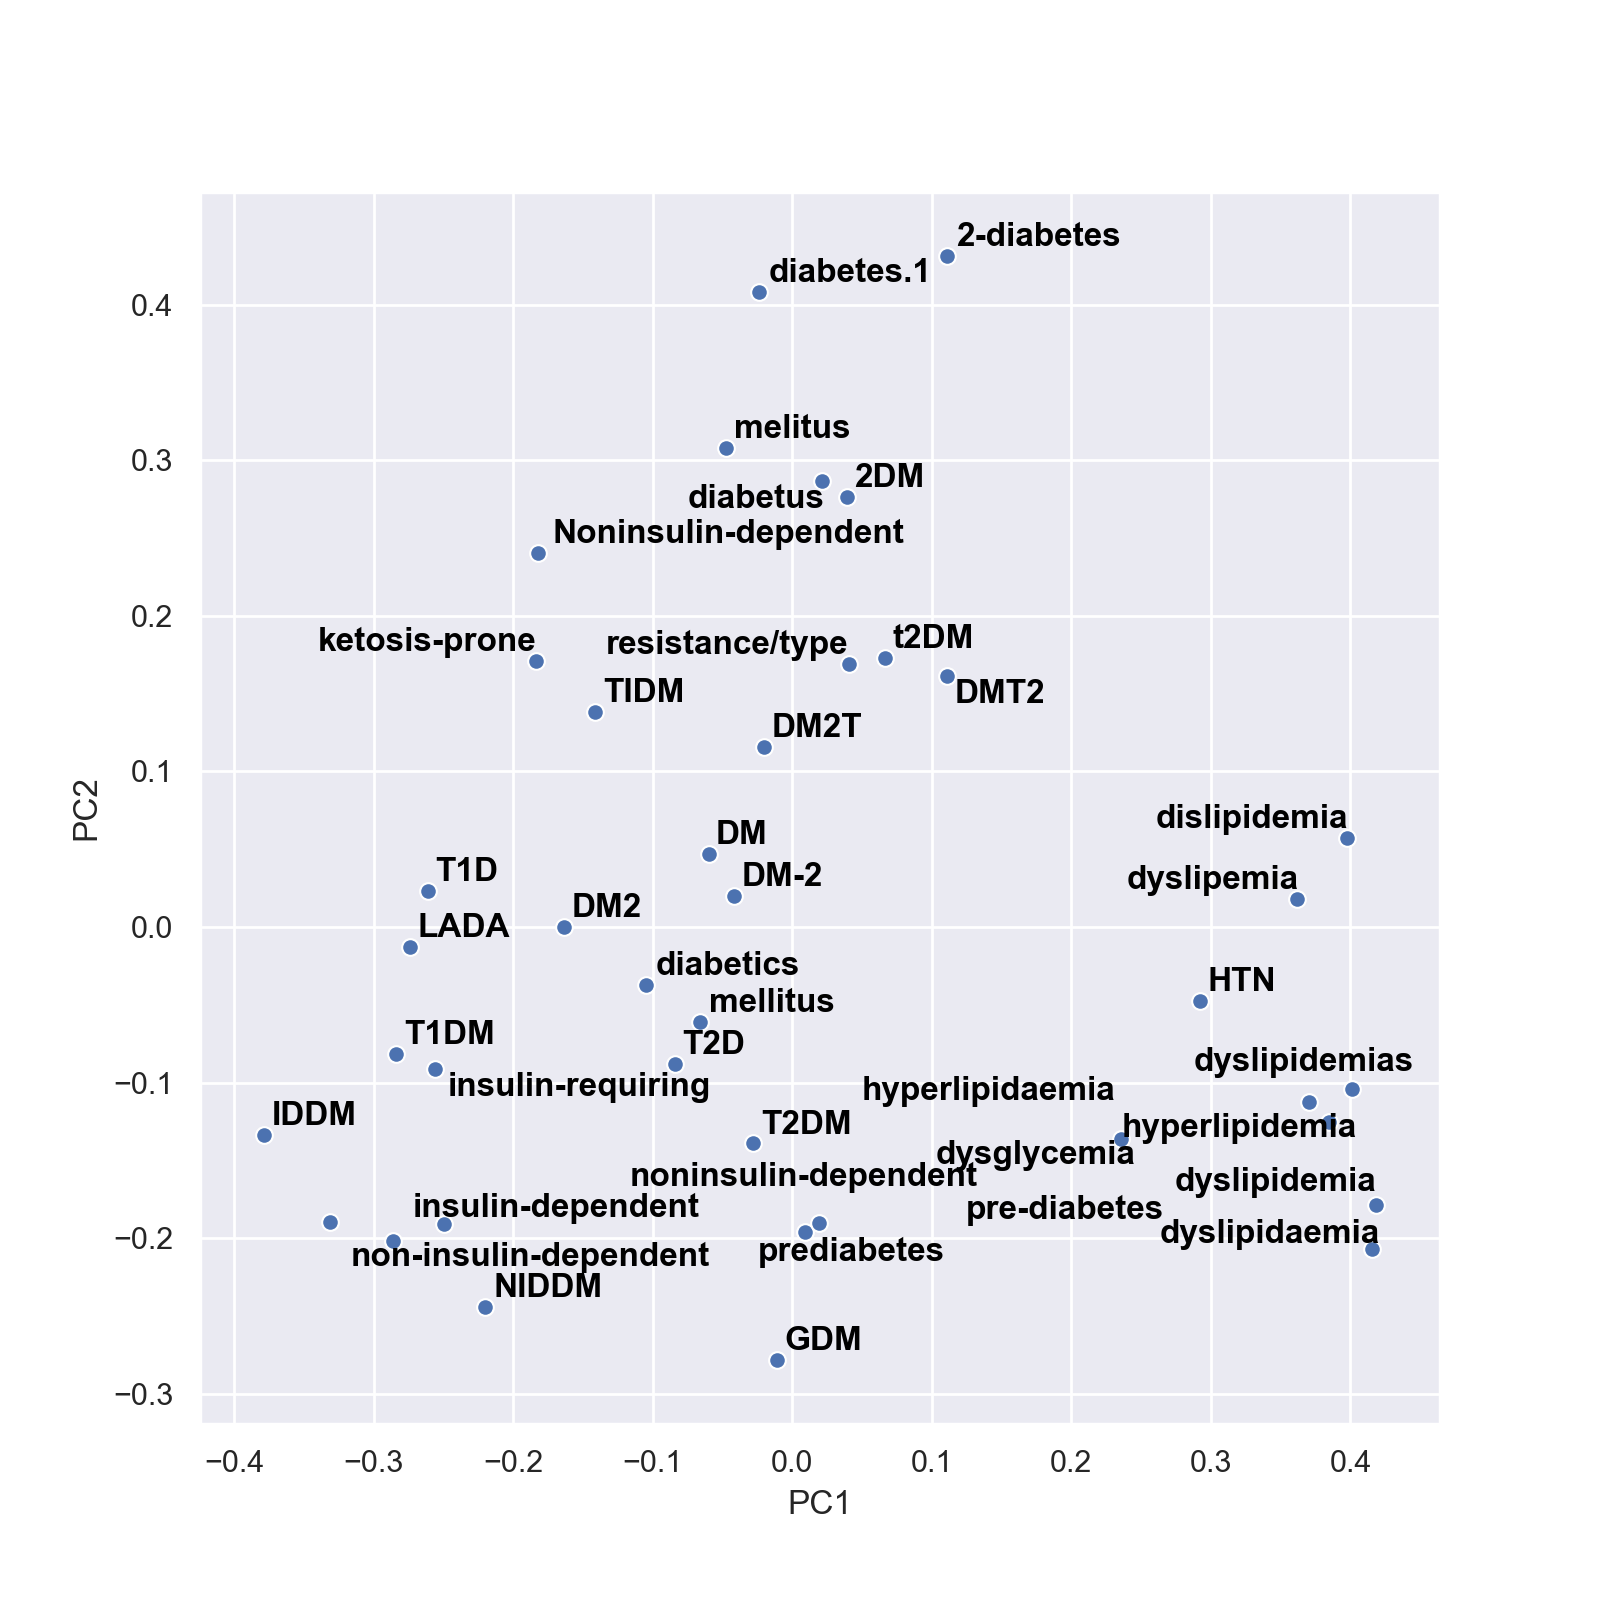

In [282]:
closest_plot('diabetes',wvn2500k,40);

<IPython.core.display.Javascript object>


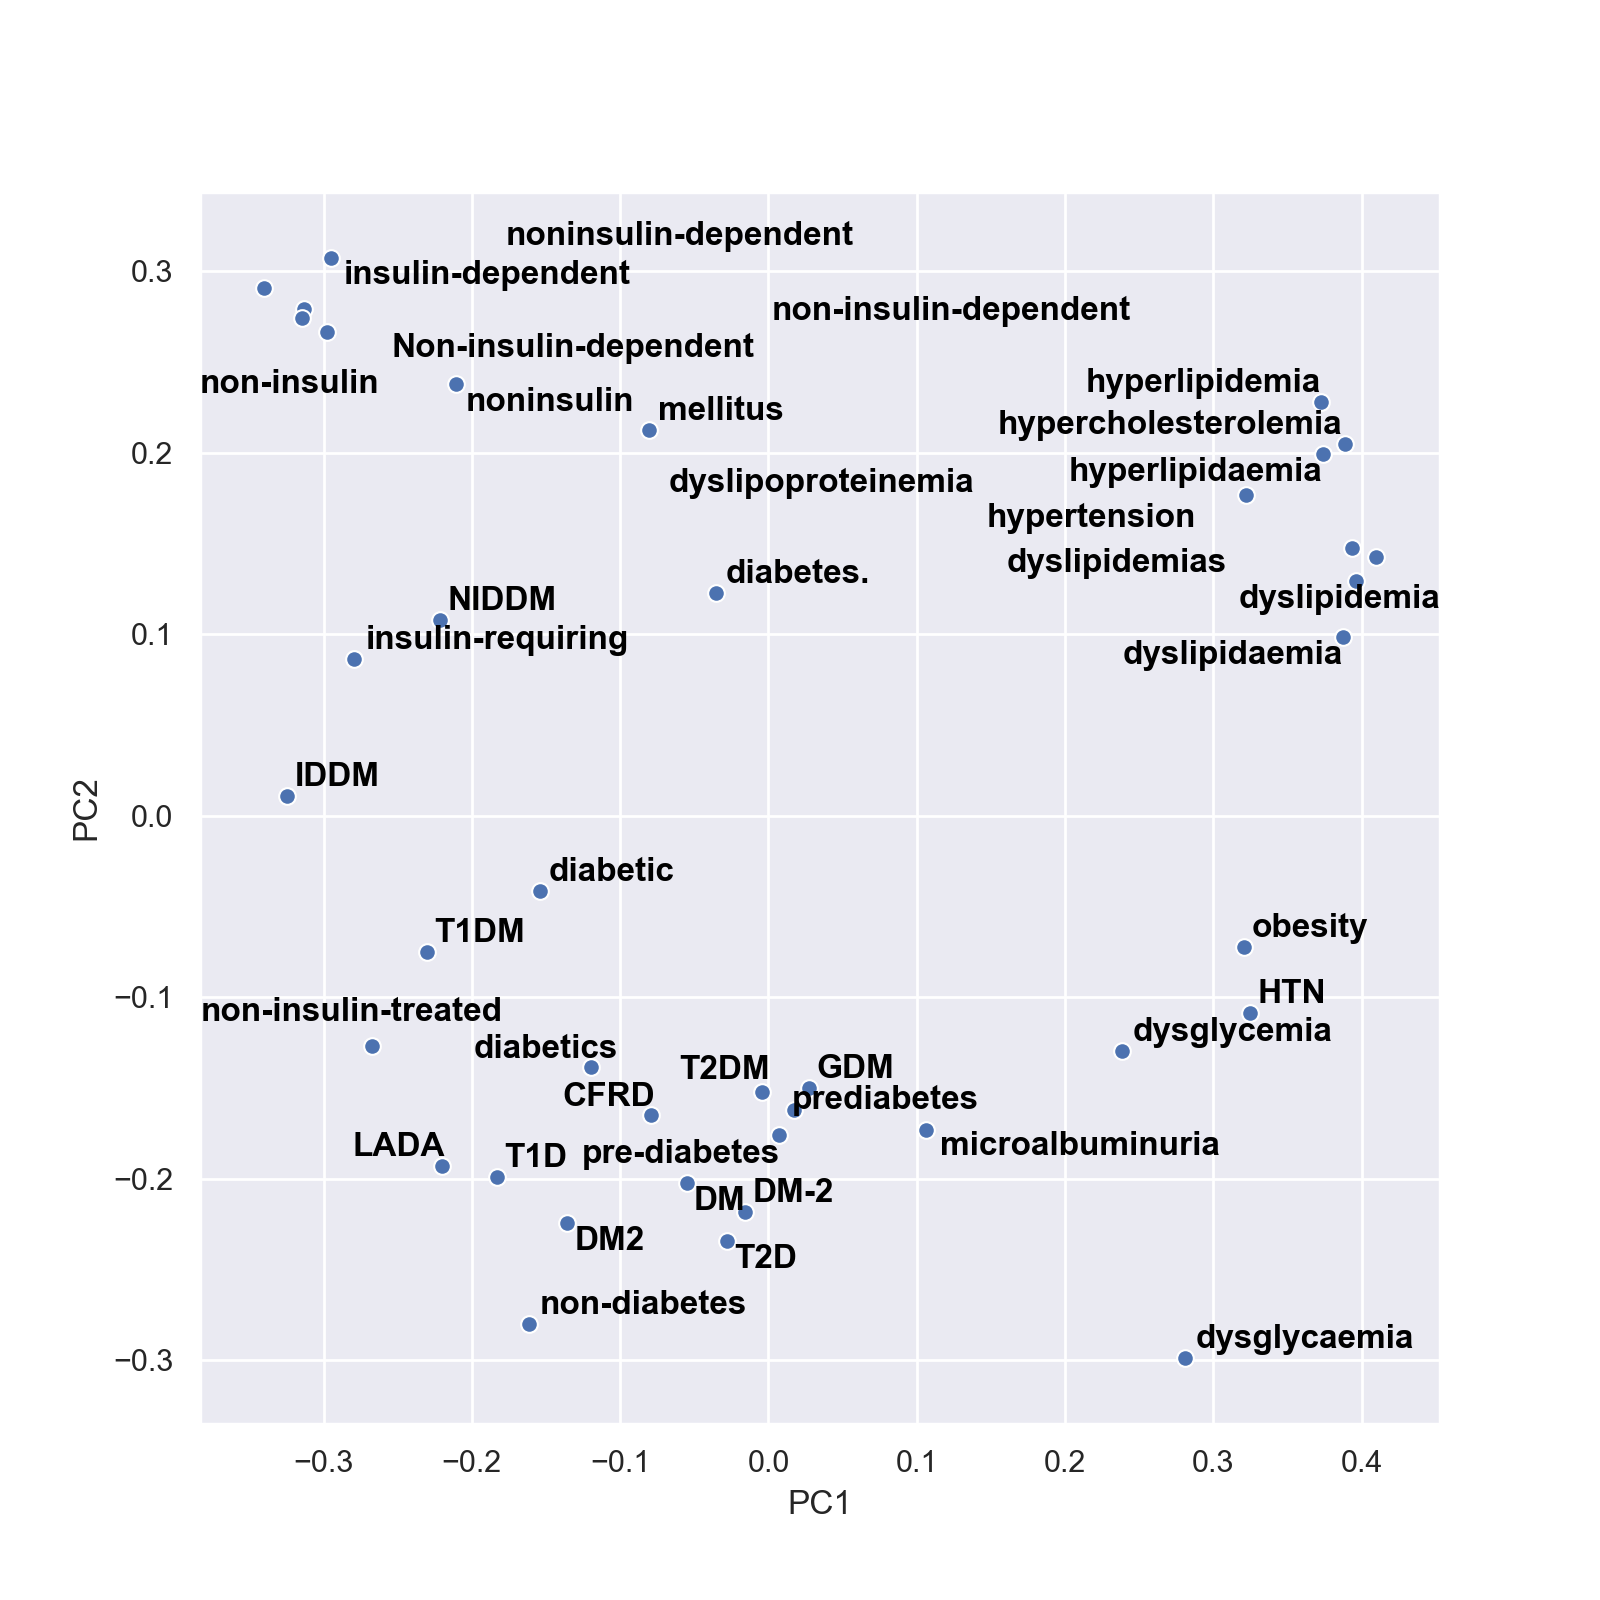

In [269]:
closest_plot('diabetes',wvn250k,40);

<IPython.core.display.Javascript object>


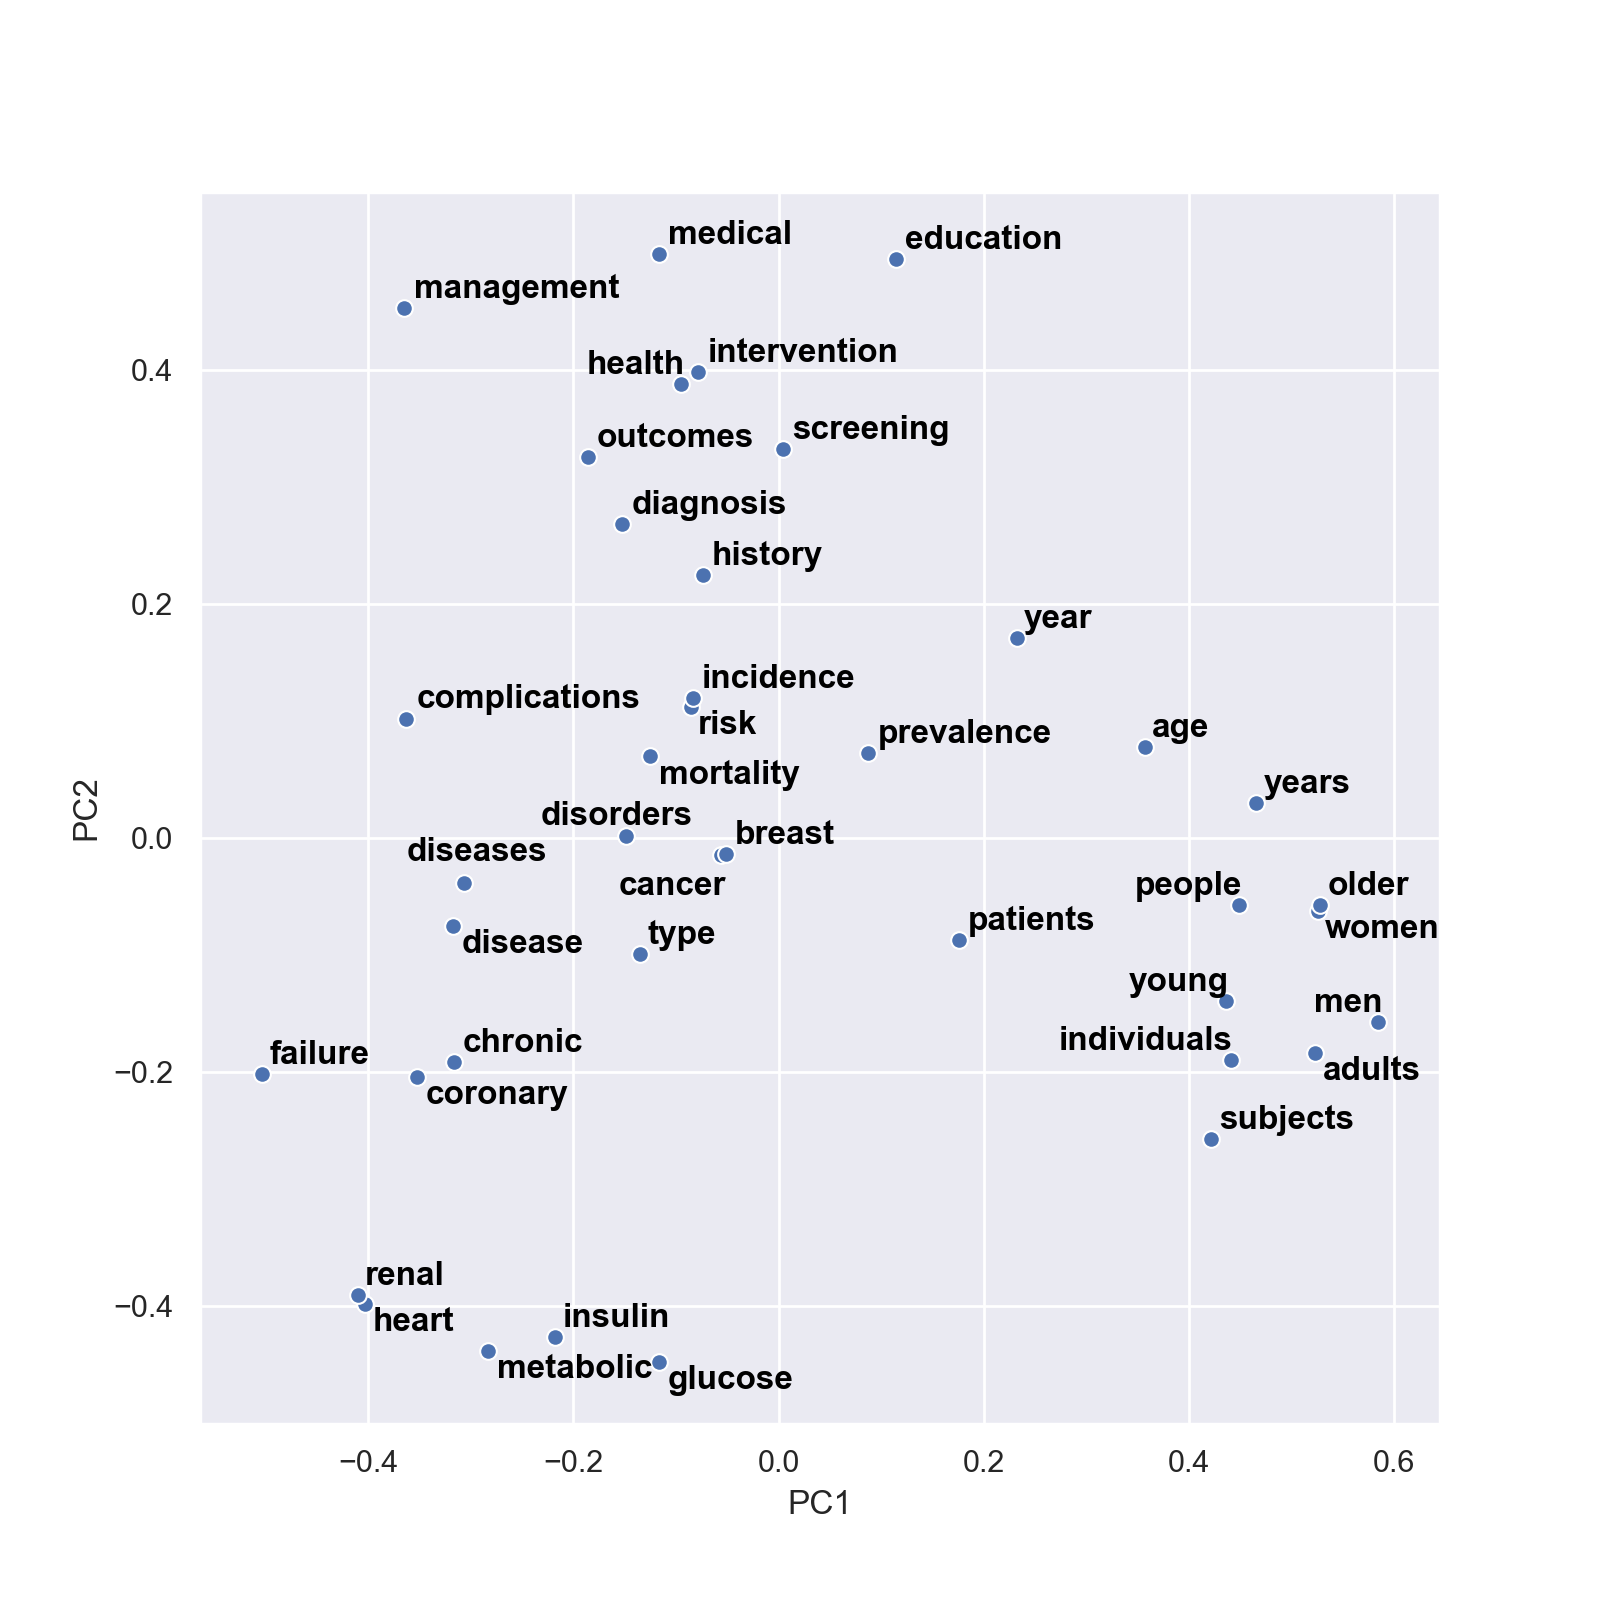

In [246]:
closest_plot('diabetes',wvn1k,40);

<IPython.core.display.Javascript object>


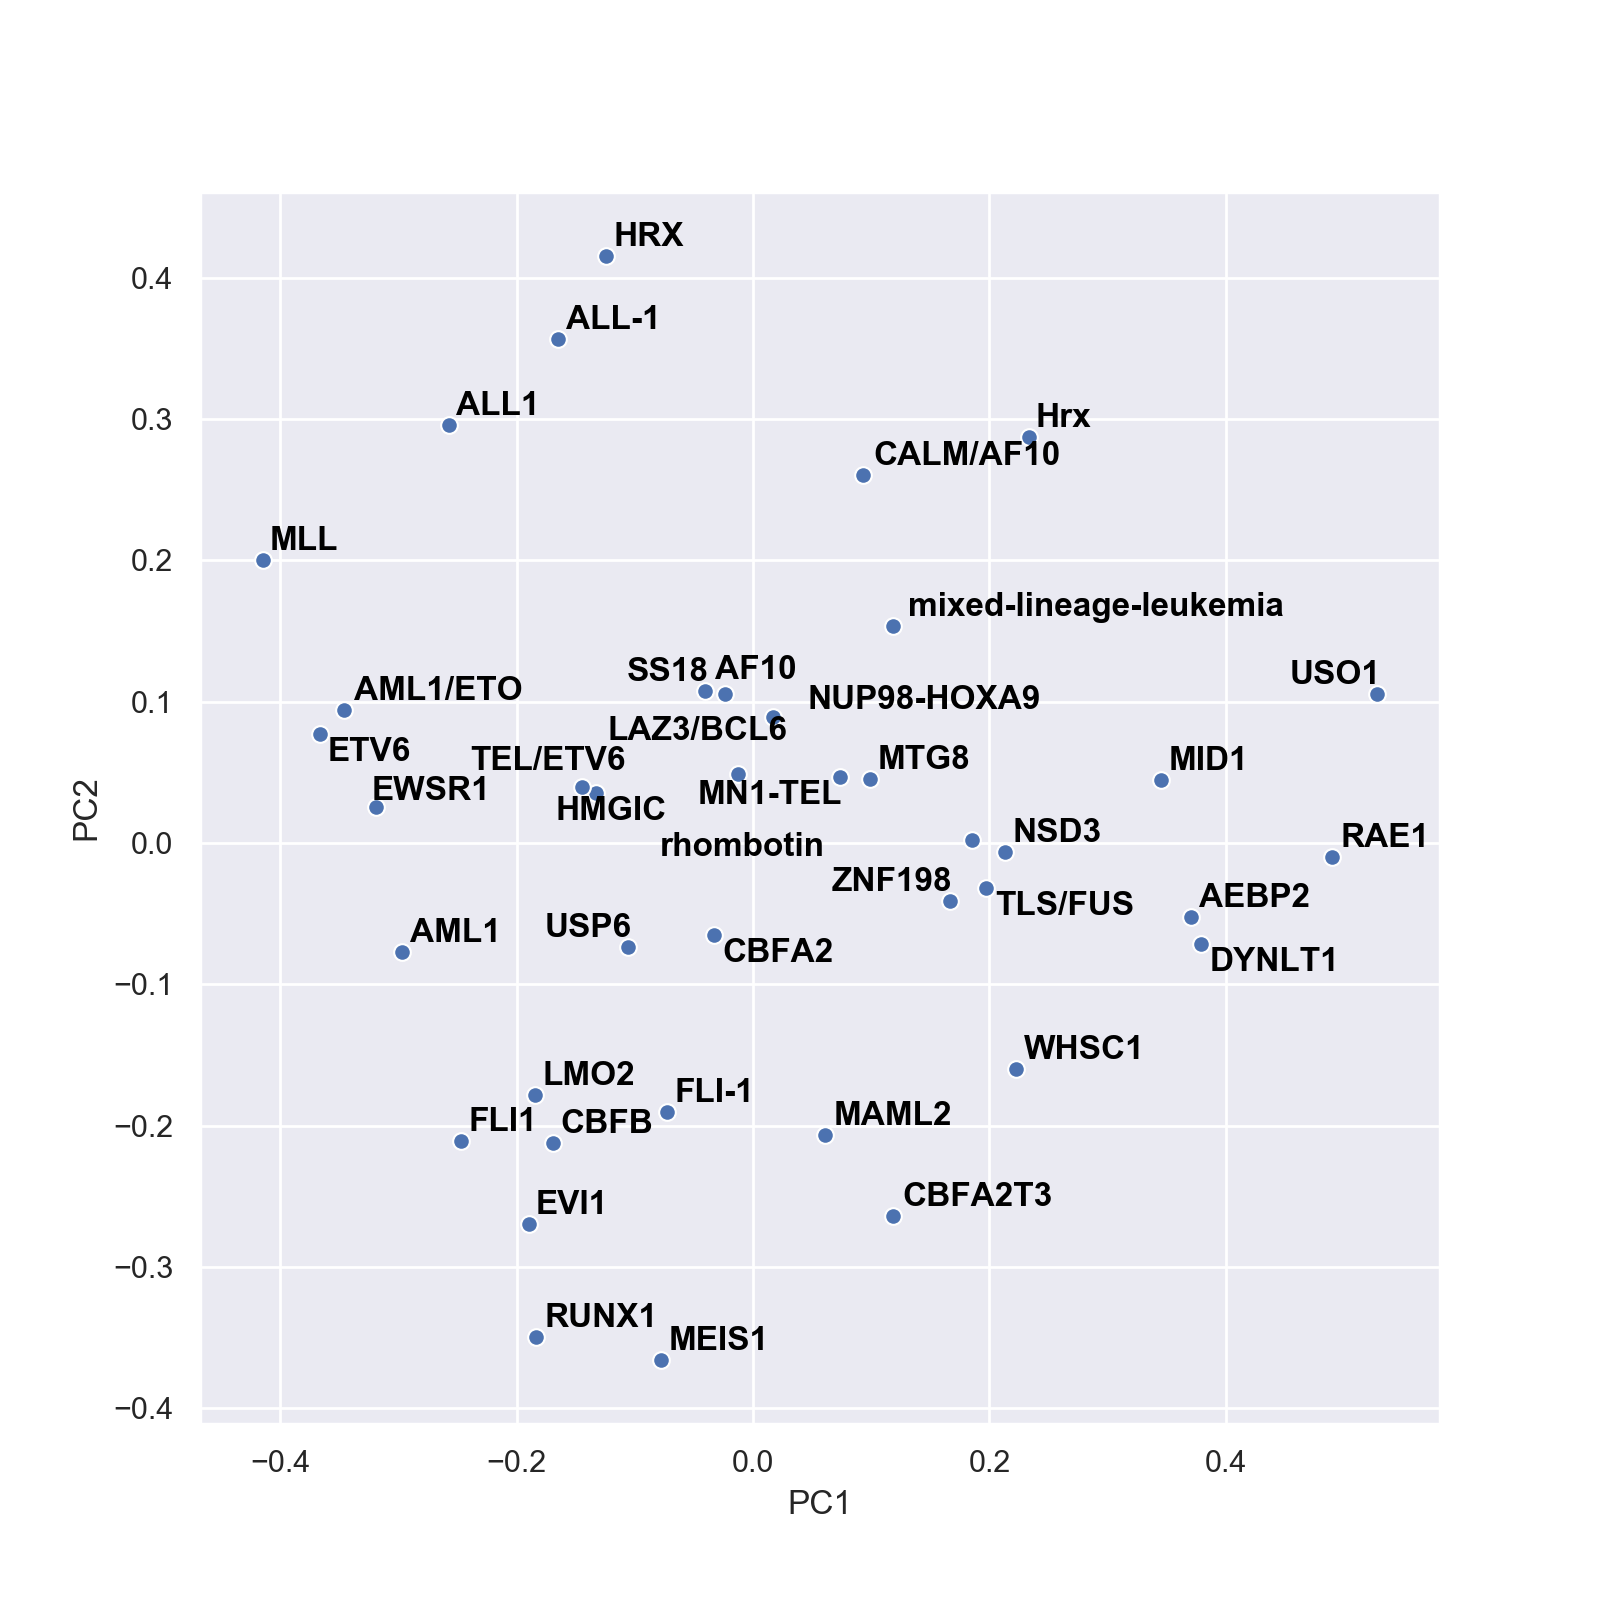

In [238]:
closest_plot('NUP98',wvn,40);

<IPython.core.display.Javascript object>


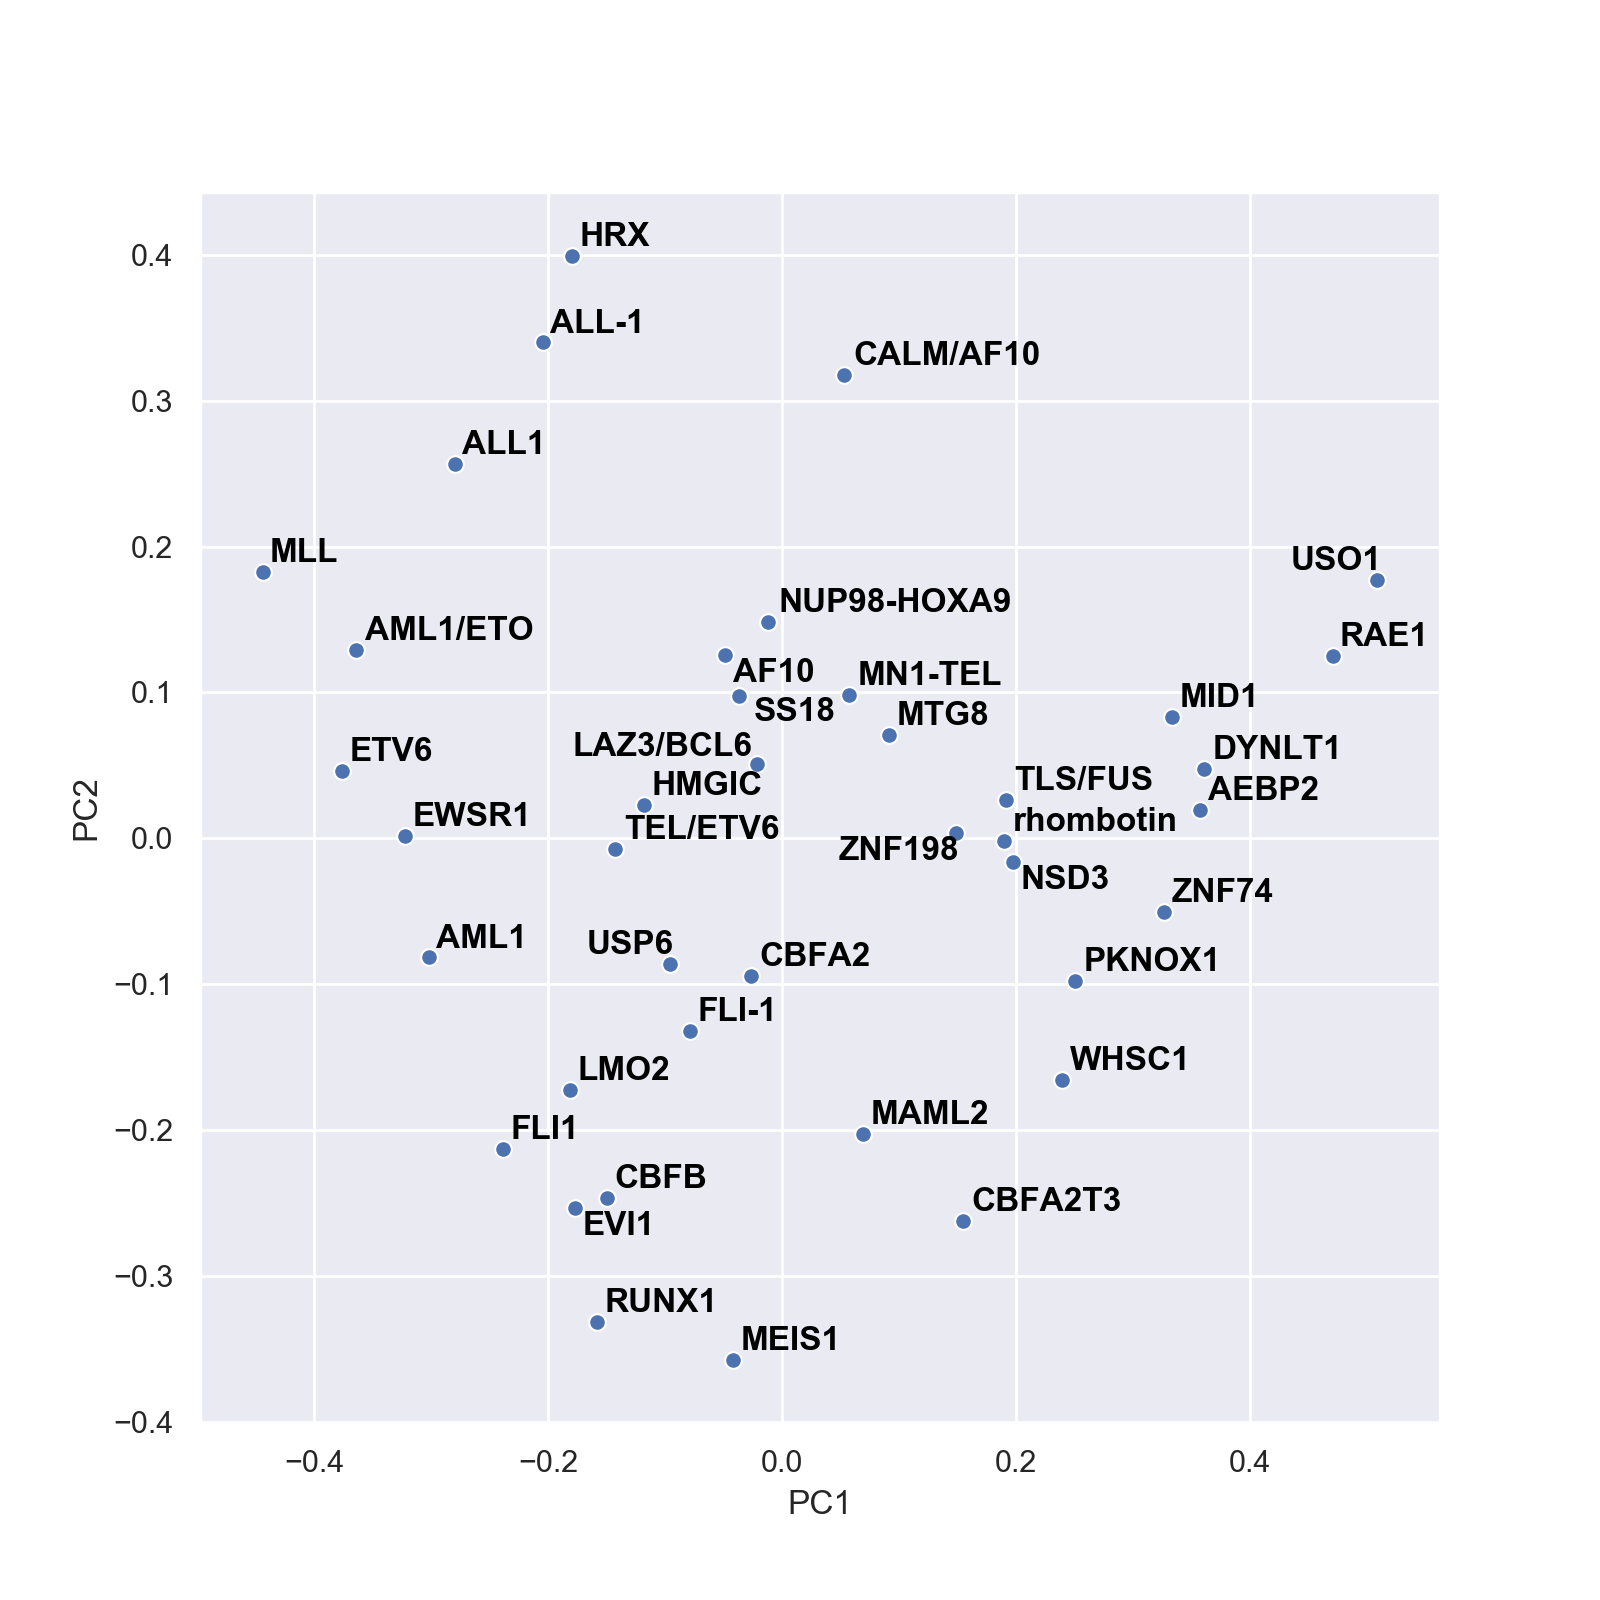

In [283]:
closest_plot('NUP98',wvn2500k,40);

<IPython.core.display.Javascript object>


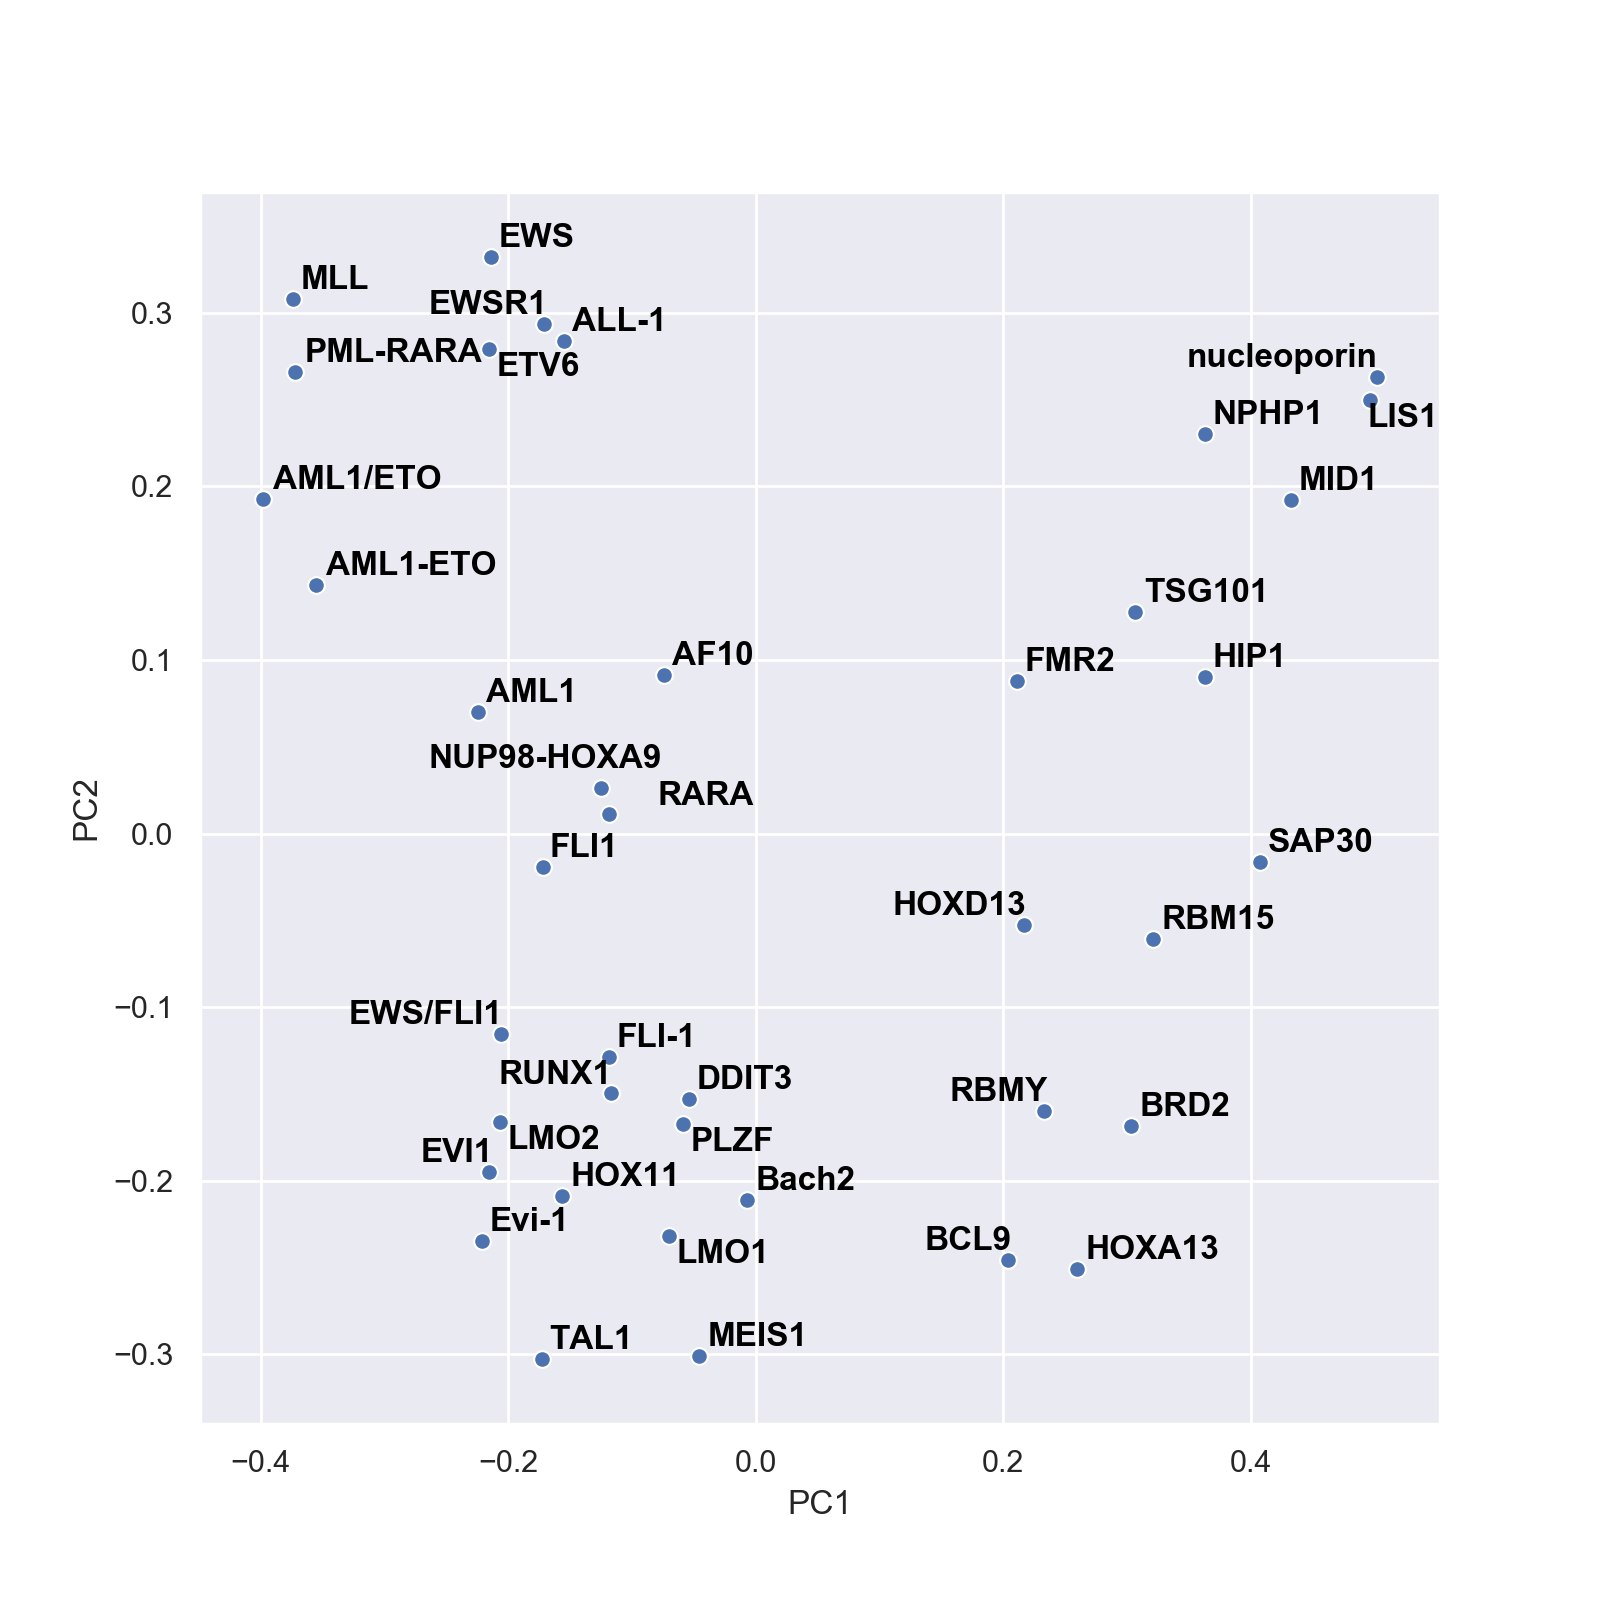

In [271]:
closest_plot('NUP98',wvn250k,40);

<IPython.core.display.Javascript object>


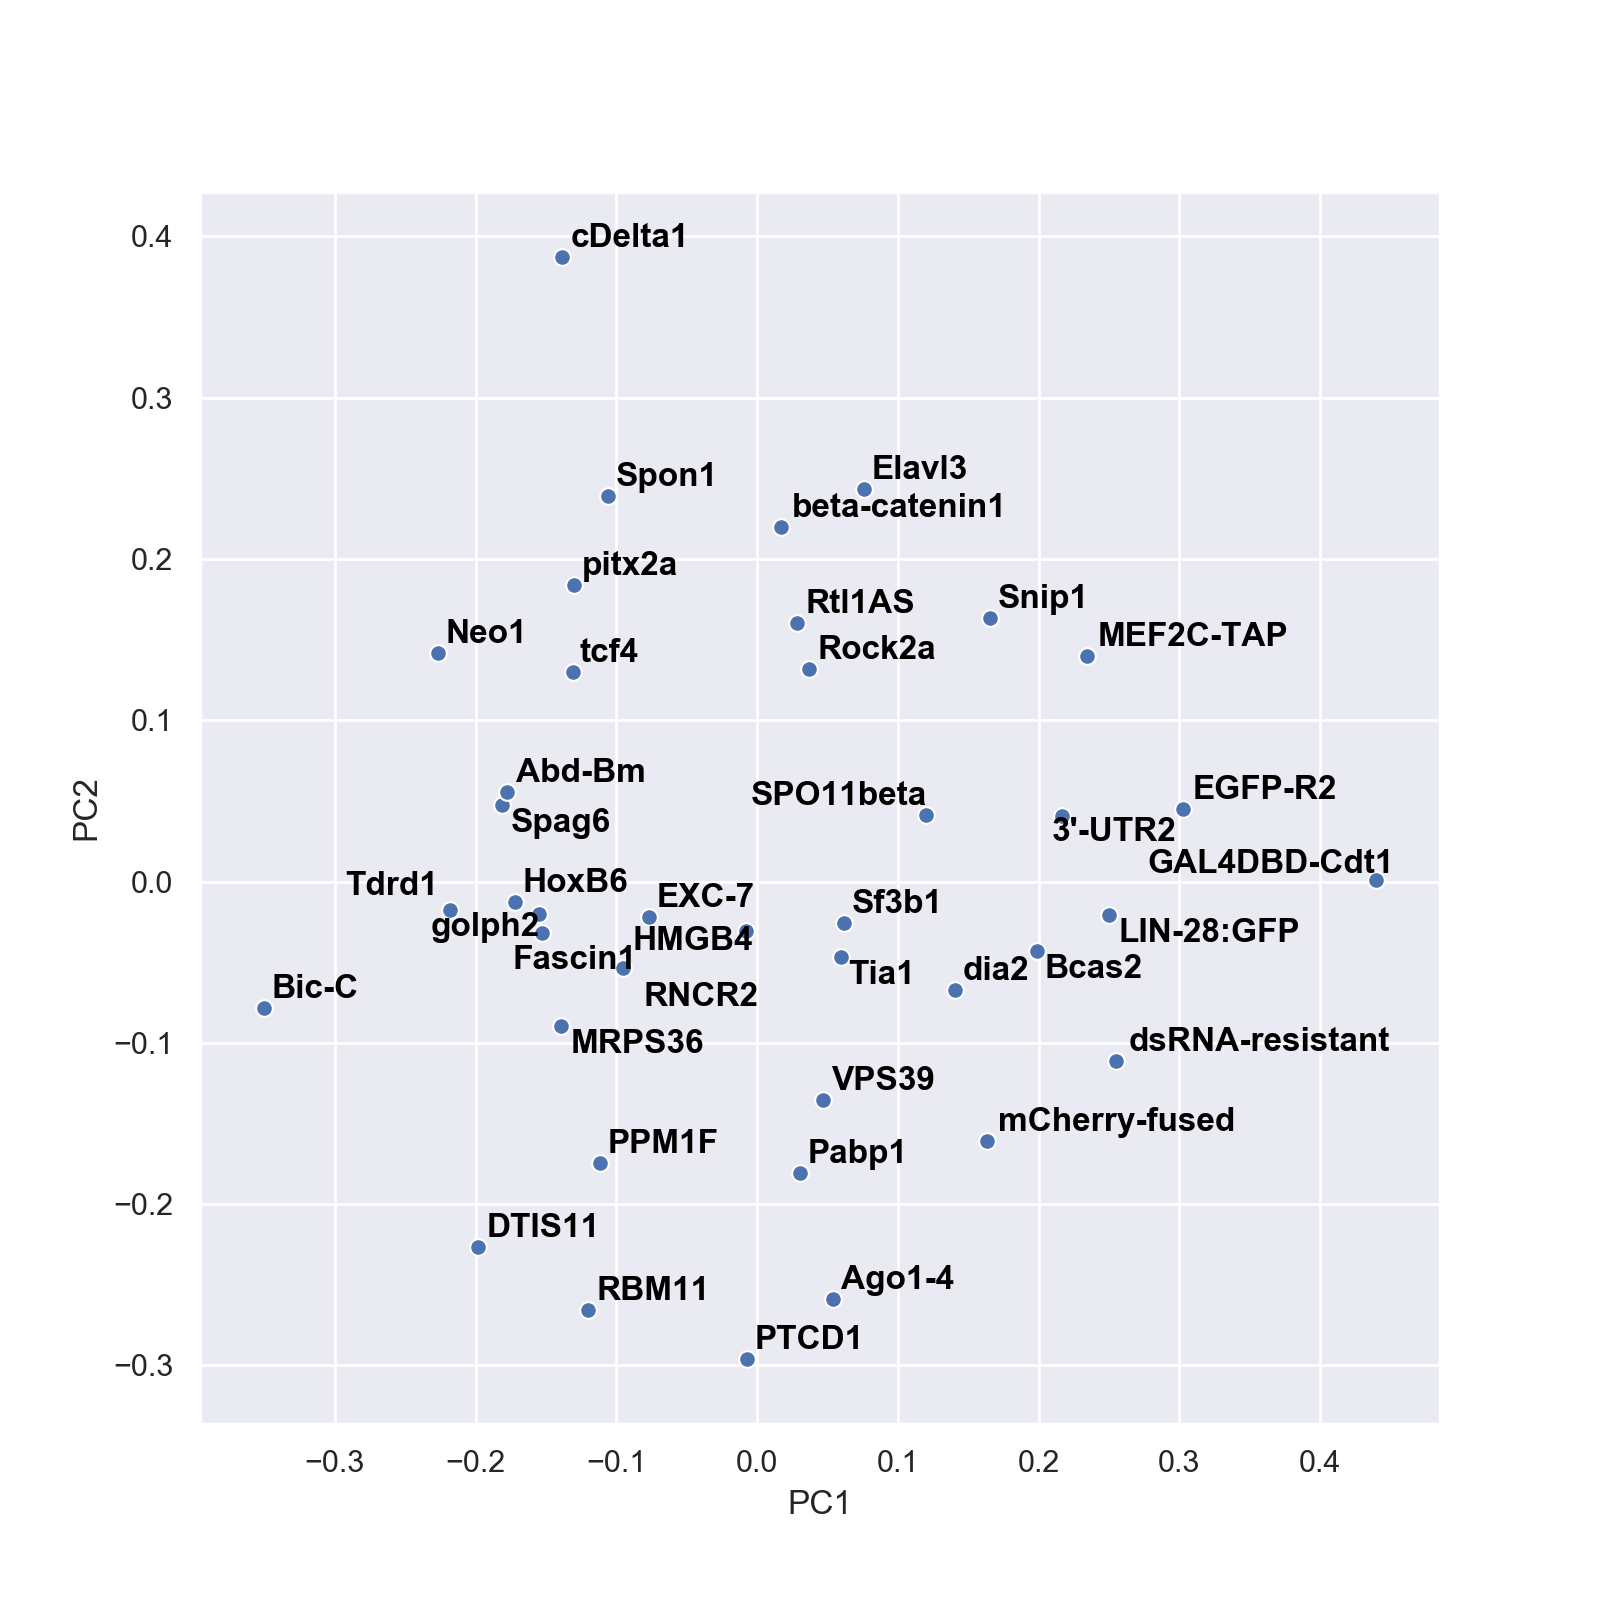

In [275]:
closest_plot('nup98',wvn,40);

<IPython.core.display.Javascript object>


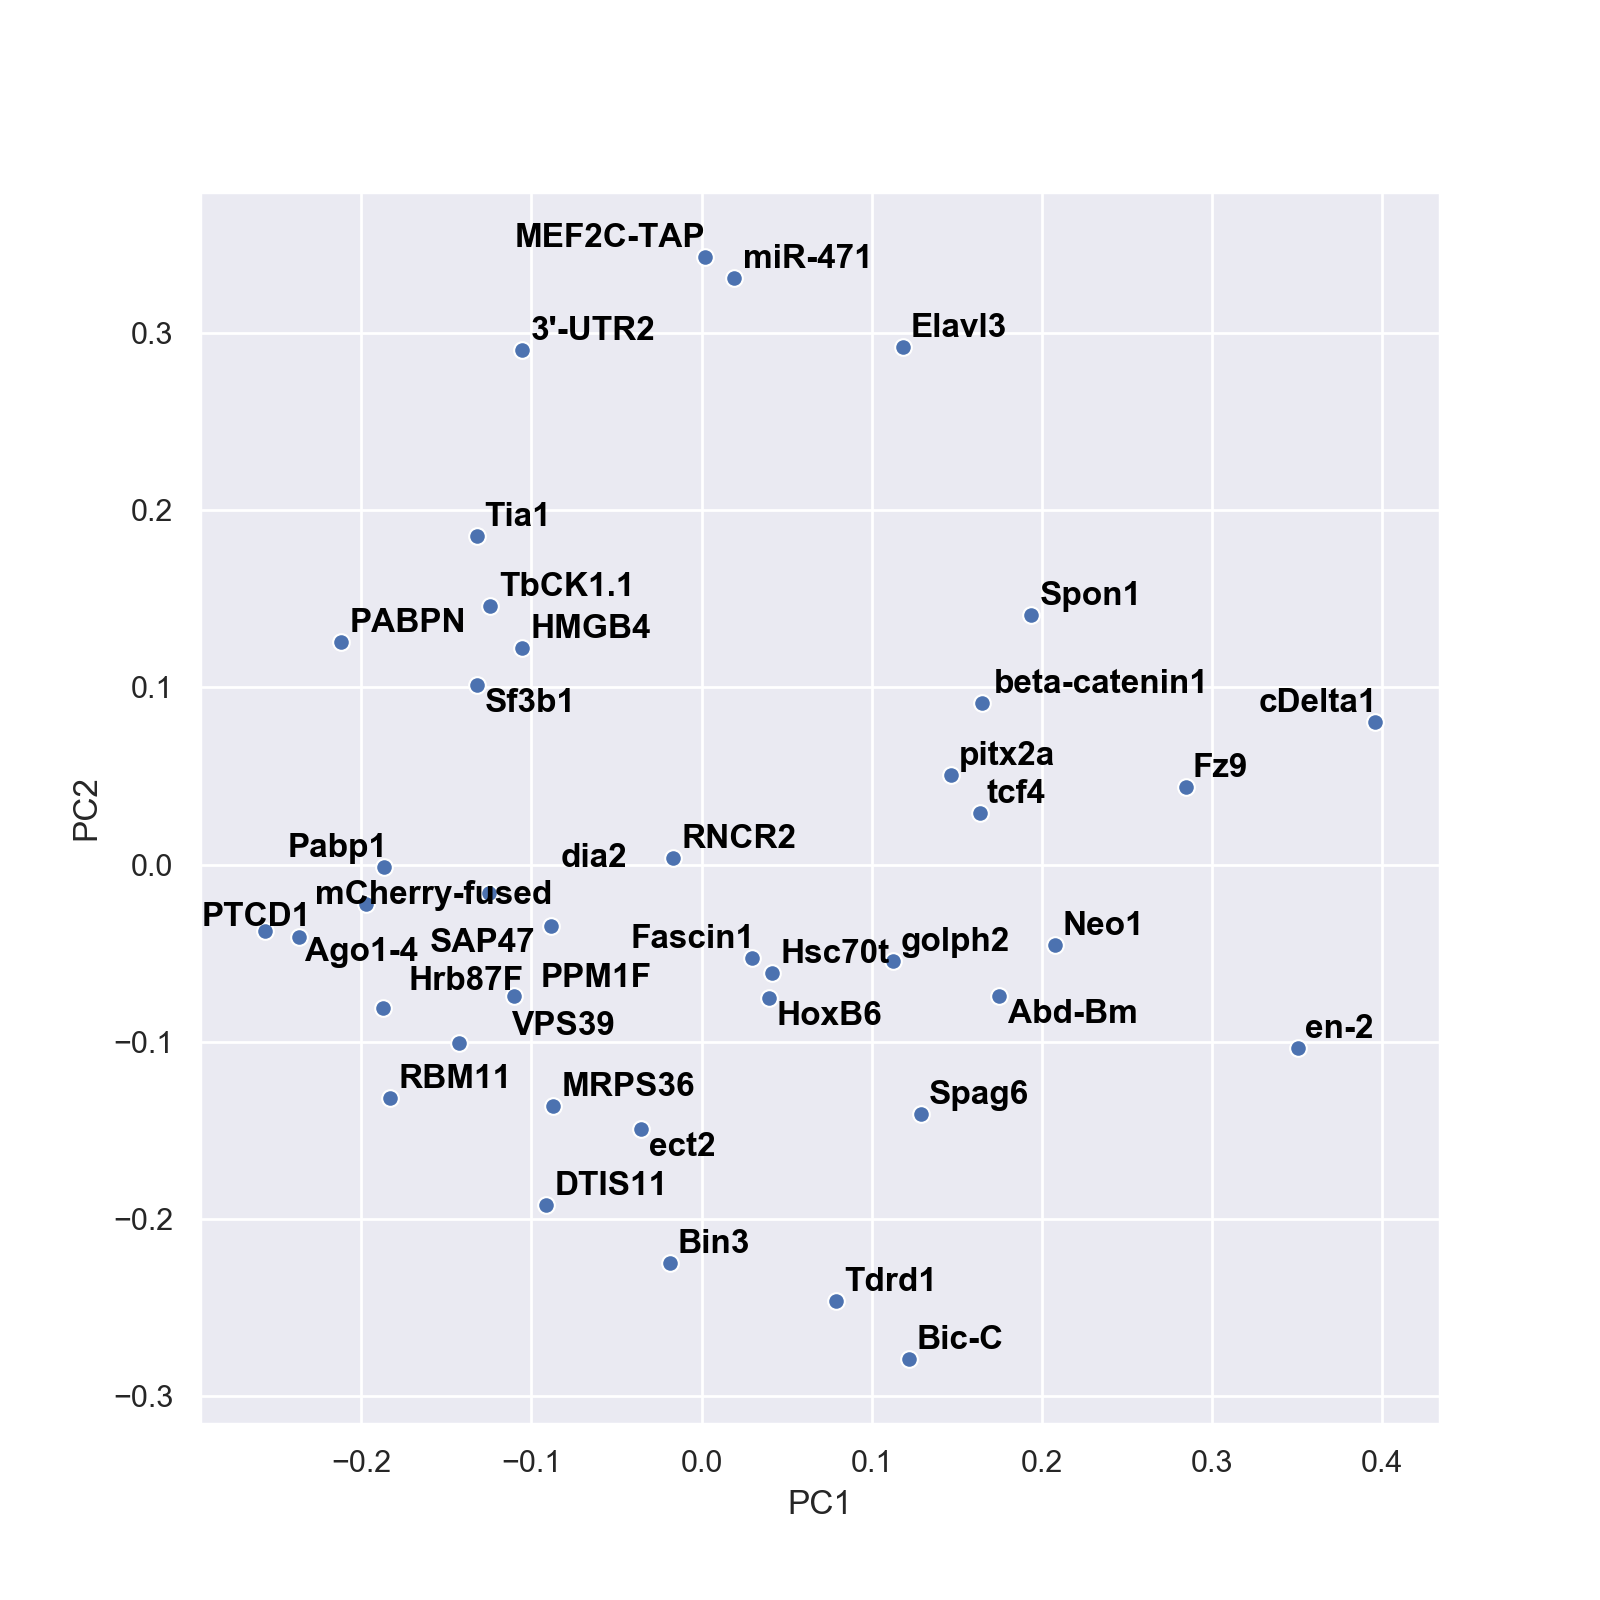

In [284]:
closest_plot('nup98',wvn2500k,40);

In [250]:
wv.vocab.word_freq['diabetes']

0

In [139]:
len(wvn10k.vectors())

NameError: name 'wvn10k' is not defined

In [267]:
tuple(wvn.vocab.word_freq.keys()).index('NUP98')

130783

In [281]:
tuple(wvn2500k.vocab.word_freq.keys()).index('nup98')

1125418

In [279]:
len(wvn.vectors())

5443656

In [266]:
wvn250k = wvn.copy().filter_by_rank(250000)

AttributeError: 'Config' object has no attribute 'copy'

In [296]:
words = rels.iloc[:,0].tolist()
words = rels.iloc[:,1].tolist() + words
wks = tuple(wvn.vocab.word_freq.keys())
plist = [wks.index(wd) for wd in words]

In [297]:
words = rels.iloc[:,0].tolist()
words = rels.iloc[:,1].tolist() + words
wks = tuple(pmwvn.vocab.word_freq.keys())
plistpm = [wks.index(wd) for wd in words]

In [299]:
pd.Series(plist).describe()

count    1.200000e+01
mean     1.532057e+05
std      3.086342e+05
min      5.591000e+03
25%      2.191450e+04
50%      6.280750e+04
75%      9.155425e+04
max      1.117611e+06
dtype: float64

In [300]:
pd.Series(plistpm).describe()

count    1.200000e+01
mean     1.290702e+05
std      2.897638e+05
min      4.079000e+03
25%      1.377350e+04
50%      4.680000e+04
75%      7.362025e+04
max      1.042633e+06
dtype: float64

In [301]:
pd.Series(plistpm).max()

1042633

In [247]:
closest_plot('NUP98',wvn10k,40);

KeyError: 'NUP98'

In [285]:
del(wv)

In [286]:
pmwvn = wvlib.load('PubMed-w2v.bin').normalize()

INFO:root:loading PubMed-w2v.bin as w2vbin
DEBUG:root:reading 2351706 vectors of size 200


In [287]:
tuple(pmwvn.vocab.word_freq.keys()).index('nup98')

804807

In [290]:
tuple(pmwvn.vocab.word_freq.keys())[1000000:1001000]

('PPARgamma-target',
 'non-ring',
 'LC-MALDI-MS/MS',
 'Nanogap',
 'D-CAT',
 'CML-collagen',
 'Whirlin',
 'RDGN',
 'PTA/stent',
 'microconidium',
 'NALP14',
 'calretinin+',
 'tRNALeu(CUN)',
 'Aqp7',
 'SENSE-DWI',
 'maxilla-facial',
 'predissected',
 'neodermatans',
 'chondrodestructive',
 'K-fibres',
 '19-kDa-interacting',
 'ANF.',
 'varus-aligned',
 '4-marker',
 'Pressurisation',
 'DHSTR',
 'D-verapamil',
 "3,3'-diClBPA",
 'CypA-CA',
 '50,8',
 'objective-oriented',
 'PMVL',
 'CAVV',
 'RPPC',
 'low-nitrosamine',
 'podded',
 '1.00-1.46',
 'Sc(3)N@C(68)',
 'post-stretching',
 'Exercise-mediated',
 'p=0.284',
 '1III',
 'kappa(0)',
 'particle-number',
 'nanopump',
 'Photonic-crystal',
 'K*0',
 'f(NL)',
 'Igi.v.',
 'cargo-free',
 'Spoor',
 'non-CYP3A4',
 'gs1',
 '4.6-7.4',
 'alloeum',
 'cefixim',
 '10.0mm',
 'lumboischiadic',
 'hyperprior',
 'V(1)/F',
 'icaAD',
 'sunshade',
 'drug-polyelectrolyte',
 'Map3k1',
 'anti-vif',
 'dibromophenol',
 'beta(+)-',
 'RbohD',
 'Cutinases',
 'H2122',
 'Gla

<IPython.core.display.Javascript object>


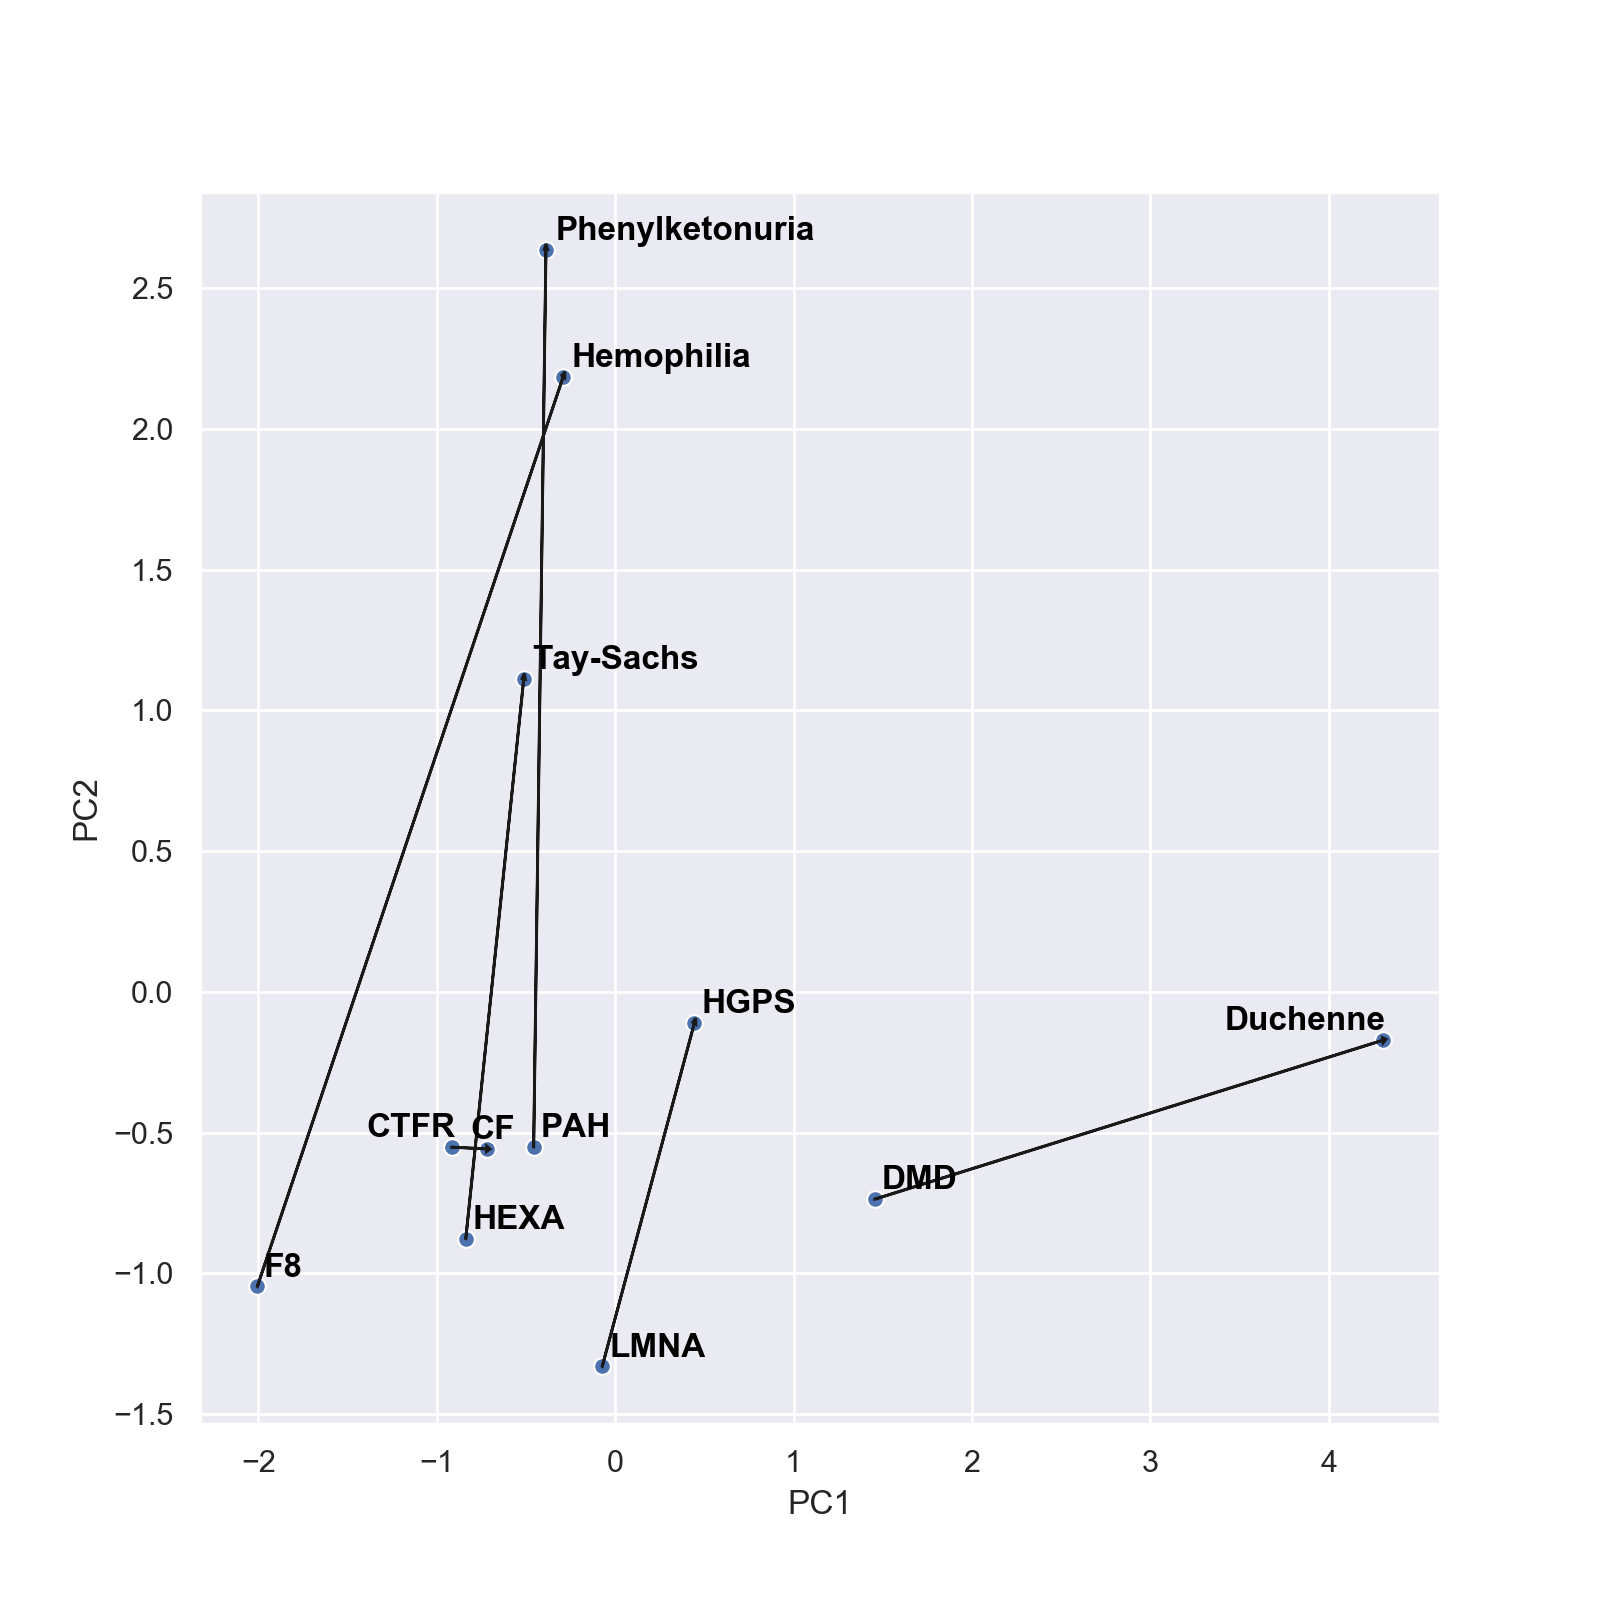

In [224]:
p1 = analogy_plot(rels,wv)

<IPython.core.display.Javascript object>


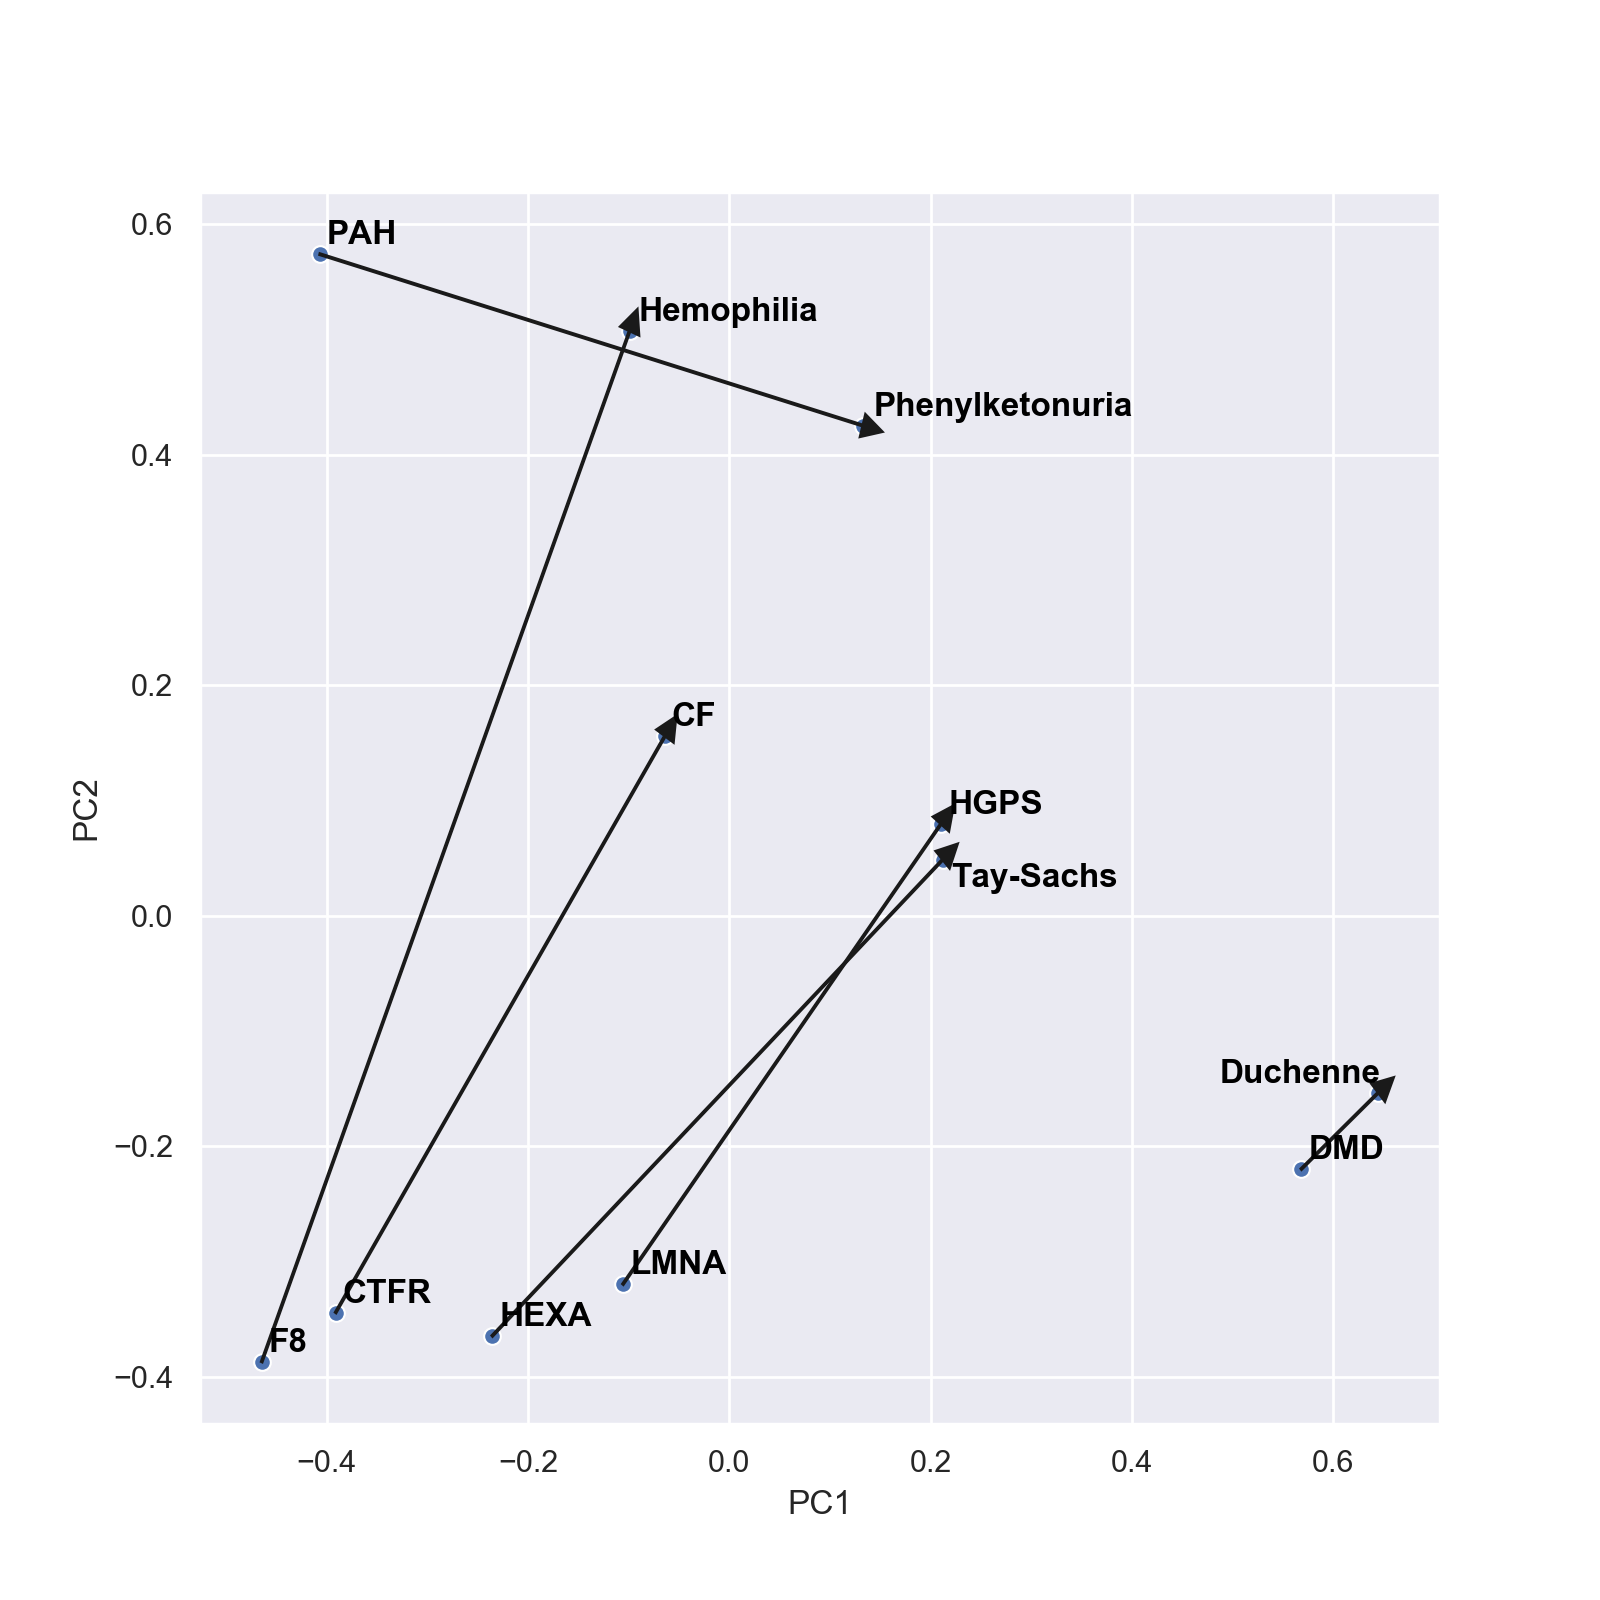

In [291]:
p1 = analogy_plot(rels,pmwvn)

In [294]:
# uses normalized wvs

num = 1000

for _,arow in wdf.iterrows():
    result = pd.DataFrame(analogy(arow.iloc[:3],wvn,num),columns=['word','similarity'])
    inthere = result.word.isin([arow.iloc[3]])
    if inthere.sum()>0:
        theone = result.loc[inthere]
        theloc = np.where(inthere)[0][0]
        print('{} - {} + {} => {}, similarity {}, rank {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2],
            theone.iloc[0,0], theone.iloc[0,1], theloc
        ))
    else:
        print('{} - {} + {} => correct answer not in top {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2], num
        ))
        


HGPS - LMNA + DMD => Duchenne, similarity 0.6056894063949585, rank 4
Hemophilia - F8 + DMD => Duchenne, similarity 0.6340276598930359, rank 2
Tay-Sachs - HEXA + DMD => Duchenne, similarity 0.5708792805671692, rank 5
CF - CTFR + DMD => Duchenne, similarity 0.527583122253418, rank 8
Phenylketonuria - PAH + DMD => Duchenne, similarity 0.5222623348236084, rank 33
Duchenne - DMD + LMNA => correct answer not in top 1000
Hemophilia - F8 + LMNA => HGPS, similarity 0.40330880880355835, rank 111
Tay-Sachs - HEXA + LMNA => HGPS, similarity 0.5262013673782349, rank 7
CF - CTFR + LMNA => HGPS, similarity 0.4085697531700134, rank 135
Phenylketonuria - PAH + LMNA => correct answer not in top 1000
Duchenne - DMD + F8 => correct answer not in top 1000
HGPS - LMNA + F8 => correct answer not in top 1000
Tay-Sachs - HEXA + F8 => correct answer not in top 1000
CF - CTFR + F8 => correct answer not in top 1000
Phenylketonuria - PAH + F8 => correct answer not in top 1000
Duchenne - DMD + HEXA => correct answe

In [293]:
# uses normalized pmwvs

num = 1000

for _,arow in wdf.iterrows():
    result = pd.DataFrame(analogy(arow.iloc[:3],pmwvn,num),columns=['word','similarity'])
    inthere = result.word.isin([arow.iloc[3]])
    if inthere.sum()>0:
        theone = result.loc[inthere]
        theloc = np.where(inthere)[0][0]
        print('{} - {} + {} => {}, similarity {}, rank {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2],
            theone.iloc[0,0], theone.iloc[0,1], theloc
        ))
    else:
        print('{} - {} + {} => correct answer not in top {}'.format(
            arow.iloc[0], arow.iloc[1], arow.iloc[2], num
        ))
        


HGPS - LMNA + DMD => Duchenne, similarity 0.5745248794555664, rank 2
Hemophilia - F8 + DMD => Duchenne, similarity 0.5387732982635498, rank 2
Tay-Sachs - HEXA + DMD => Duchenne, similarity 0.6681679487228394, rank 1
CF - CTFR + DMD => Duchenne, similarity 0.5752221345901489, rank 2
Phenylketonuria - PAH + DMD => Duchenne, similarity 0.6661738157272339, rank 1
Duchenne - DMD + LMNA => correct answer not in top 1000
Hemophilia - F8 + LMNA => correct answer not in top 1000
Tay-Sachs - HEXA + LMNA => HGPS, similarity 0.44666600227355957, rank 323
CF - CTFR + LMNA => HGPS, similarity 0.3014140725135803, rank 662
Phenylketonuria - PAH + LMNA => correct answer not in top 1000
Duchenne - DMD + F8 => correct answer not in top 1000
HGPS - LMNA + F8 => correct answer not in top 1000
Tay-Sachs - HEXA + F8 => correct answer not in top 1000
CF - CTFR + F8 => correct answer not in top 1000
Phenylketonuria - PAH + F8 => correct answer not in top 1000
Duchenne - DMD + HEXA => correct answer not in top 

In [302]:
del(wvn2500k)
del(wvn10k)
del(wvn5k)
del(wvn1k)
del(wvn)
del(pmwvn)

In [140]:
who

LeaveOneOut	 LinearDiscriminantAnalysis	 X	 Xt	 accuracy_score	 adjust_text	 analogy	 analogy_plot	 analogy_sets	 
apprx_analogy	 arow	 ax	 closest_plot	 cm	 confusion_matrix	 cval	 dfs	 dgtarget	 
display_labels	 f1_score	 fig	 idx	 model	 n_classes	 np	 p1	 pd	 
plt	 pm_wv_n_1500k	 pred	 rels	 reltarget	 skl	 sklearn	 sns	 test	 
tmp	 train	 treu	 true	 vecs	 warnings	 wdf	 words	 wpm_wv_n_1500k	 
wvlib	 y	 yh	 yl	 yt	 
